## Prédiction du taux d'attrition au sein d'une banque de détail.

### Importation des librairies

In [1]:
!pip install -r ../requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) #ces quatres lignes servent à afficher plus de 10 lignes par requète
pd.set_option('display.max_rows', None)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from collections import Counter
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pyod.models.iforest import IForest
import pyarrow.parquet as pq
import os
import pyarrow as pa
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
import mlflow
import mlflow.sklearn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
import sys
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import openpyxl

In [3]:
import subprocess
import threading

def run_mlflow_ui():
    subprocess.run(["mlflow", "ui"])

thread = threading.Thread(target=run_mlflow_ui)
thread.start()

In [4]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Churn_Prediction")

<Experiment: artifact_location='mlflow-artifacts:/214582553551648824', creation_time=1726731290082, experiment_id='214582553551648824', last_update_time=1726731290082, lifecycle_stage='active', name='Churn_Prediction', tags={}>

### Importation du jeu de données

In [5]:
data_path = "../data/raw/dataset.csv"
df = pd.read_csv(data_path, delimiter=';')
display(df.head())

,id_client,genre,espace_client_web,assurance_vie,banque_principale,anciennete_mois,compte_epargne,credit_autres,cartes_bancaires,compte_courant,espace_client,PEA,assurance_auto,assurance_habitation,credit_immo,type,compte_titres,methode_contact,agios_6mois,interet_compte_epargne_total,age,segment_client,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,branche,churn
0,3463,H,0.0,non,non,37.0,oui,consommation,medium,oui,non,non,non,oui,non,pro,oui,mail,91.15,3369.25,30.0,A4,3788.182745,5945.077267,10803.089959,13030.928518,16070.855640,17019.439852,22021.785596,21216.423900,23817.283384,24696.468636,NaN,29133.894497,27300.071162,26686.065056,29058.920542,30081.575645,34737.732143,35668.424115,42088.923198,42764.084114,1169.512733,1476.735096,2906.612116,4238.286461,6541.289876,5604.843020,8529.610222,6698.675290,8299.637103,8584.519863,8285.480439,13545.535937,12243.785415,12140.590245,9013.777747,11604.261036,16390.415593,14631.204899,23988.305931,NORD-OUEST,non
1,1869,H,0.0,oui,oui,72.0,oui,consommation,premium,inconnu,inconnu,inconnu,inconnu,inconnu,inconnu,NaN,non,sms,24.10,1734.65,53.0,B1,13256.481090,13857.639282,16921.648902,15994.602590,19860.270780,21737.139931,24324.244241,27392.121666,29288.212735,31119.430165,32536.150958,33491.895175,36037.986828,37906.966495,37065.723883,36662.943135,35995.908243,38504.550415,39879.461696,40351.659648,4040.767255,2893.438448,4522.323311,3289.390612,8409.097755,5939.488953,6615.523133,8423.928612,9664.847859,12811.297554,13850.568156,14014.989673,15508.546834,17547.988381,15470.524076,17537.628474,17410.472648,21258.908987,21554.411100,NORD-OUEST,non
2,3760,H,0.0,non,non,3.0,oui,NaN,medium,non,non,oui,non,non,non,pro,oui,sms,73.60,232.5,41.0,B2,6485.760225,8854.292447,14631.403255,16403.253266,20053.910352,24404.311456,NaN,NaN,28995.145157,31381.332311,34524.328158,37696.137418,40010.389451,39991.336181,42066.099905,46159.092725,46548.328134,49017.799992,50879.800091,50811.414357,641.888116,2194.386006,4719.557270,5592.923372,6652.559765,11578.741807,10784.182742,10408.668590,11426.817452,11686.025962,16764.322564,17239.846026,19479.322456,21343.802381,24084.291026,25823.493343,25839.829752,25587.814976,29736.376226,NORD-OUEST,non
3,3820,H,1.0,oui,non,72.0,oui,consommation,medium,oui,oui,oui,oui,NaN,oui,pro,oui,sms,112.90,8061.5,44.0,C4,3023.518886,3657.280381,3583.864370,7048.335851,10851.522505,13233.449469,17043.445440,17315.324866,18409.009200,20992.136261,25680.971636,26021.839063,28987.451966,28467.733523,30863.437099,NaN,35443.442964,42466.157213,47617.669527,50441.094534,846.588009,300.647893,NaN,623.554669,1411.534141,2919.154899,4837.868424,6297.571985,4694.966744,8601.779273,6895.959437,9229.470887,11935.244779,11014.748509,11791.353542,16354.051367,15449.967495,21149.789933,29211.314803,NORD-OUEST,non
4,1463,F,0.0,non,non,4.0,oui,permanent,medium,non,non,non,non,non,non,pro,non,mail,70.40,281,32.0,B2,5108.994106,4922.134385,5619.387384,5967.906772,11720.904970,15561.132418,14934.624990,16295.563660,18983.711353,20997.917940,23264.257596,21750.759870,19947.127129,20916.130056,21685.913416,23620.334323,24778.901653,22870.646400,25475.278671,28725.910656,533.782193,977.257244,782.571668,1830.376484,2025.910611,2696.413807,2883.741954,4206.610511,4990.114457,7081.966623,8472.294920,9008.641700,5875.342745,6101.742525,8026.508871,10361.246523,10575.966610,6714.625315,9101.978017,NORD-OUEST,oui


### Exploration préliminaire du jeu de données

In [6]:
df.head()

,id_client,genre,espace_client_web,assurance_vie,banque_principale,anciennete_mois,compte_epargne,credit_autres,cartes_bancaires,compte_courant,espace_client,PEA,assurance_auto,assurance_habitation,credit_immo,type,compte_titres,methode_contact,agios_6mois,interet_compte_epargne_total,age,segment_client,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,branche,churn
0,3463,H,0.0,non,non,37.0,oui,consommation,medium,oui,non,non,non,oui,non,pro,oui,mail,91.15,3369.25,30.0,A4,3788.182745,5945.077267,10803.089959,13030.928518,16070.855640,17019.439852,22021.785596,21216.423900,23817.283384,24696.468636,NaN,29133.894497,27300.071162,26686.065056,29058.920542,30081.575645,34737.732143,35668.424115,42088.923198,42764.084114,1169.512733,1476.735096,2906.612116,4238.286461,6541.289876,5604.843020,8529.610222,6698.675290,8299.637103,8584.519863,8285.480439,13545.535937,12243.785415,12140.590245,9013.777747,11604.261036,16390.415593,14631.204899,23988.305931,NORD-OUEST,non
1,1869,H,0.0,oui,oui,72.0,oui,consommation,premium,inconnu,inconnu,inconnu,inconnu,inconnu,inconnu,NaN,non,sms,24.10,1734.65,53.0,B1,13256.481090,13857.639282,16921.648902,15994.602590,19860.270780,21737.139931,24324.244241,27392.121666,29288.212735,31119.430165,32536.150958,33491.895175,36037.986828,37906.966495,37065.723883,36662.943135,35995.908243,38504.550415,39879.461696,40351.659648,4040.767255,2893.438448,4522.323311,3289.390612,8409.097755,5939.488953,6615.523133,8423.928612,9664.847859,12811.297554,13850.568156,14014.989673,15508.546834,17547.988381,15470.524076,17537.628474,17410.472648,21258.908987,21554.411100,NORD-OUEST,non
2,3760,H,0.0,non,non,3.0,oui,NaN,medium,non,non,oui,non,non,non,pro,oui,sms,73.60,232.5,41.0,B2,6485.760225,8854.292447,14631.403255,16403.253266,20053.910352,24404.311456,NaN,NaN,28995.145157,31381.332311,34524.328158,37696.137418,40010.389451,39991.336181,42066.099905,46159.092725,46548.328134,49017.799992,50879.800091,50811.414357,641.888116,2194.386006,4719.557270,5592.923372,6652.559765,11578.741807,10784.182742,10408.668590,11426.817452,11686.025962,16764.322564,17239.846026,19479.322456,21343.802381,24084.291026,25823.493343,25839.829752,25587.814976,29736.376226,NORD-OUEST,non
3,3820,H,1.0,oui,non,72.0,oui,consommation,medium,oui,oui,oui,oui,NaN,oui,pro,oui,sms,112.90,8061.5,44.0,C4,3023.518886,3657.280381,3583.864370,7048.335851,10851.522505,13233.449469,17043.445440,17315.324866,18409.009200,20992.136261,25680.971636,26021.839063,28987.451966,28467.733523,30863.437099,NaN,35443.442964,42466.157213,47617.669527,50441.094534,846.588009,300.647893,NaN,623.554669,1411.534141,2919.154899,4837.868424,6297.571985,4694.966744,8601.779273,6895.959437,9229.470887,11935.244779,11014.748509,11791.353542,16354.051367,15449.967495,21149.789933,29211.314803,NORD-OUEST,non
4,1463,F,0.0,non,non,4.0,oui,permanent,medium,non,non,non,non,non,non,pro,non,mail,70.40,281,32.0,B2,5108.994106,4922.134385,5619.387384,5967.906772,11720.904970,15561.132418,14934.624990,16295.563660,18983.711353,20997.917940,23264.257596,21750.759870,19947.127129,20916.130056,21685.913416,23620.334323,24778.901653,22870.646400,25475.278671,28725.910656,533.782193,977.257244,782.571668,1830.376484,2025.910611,2696.413807,2883.741954,4206.610511,4990.114457,7081.966623,8472.294920,9008.641700,5875.342745,6101.742525,8026.508871,10361.246523,10575.966610,6714.625315,9101.978017,NORD-OUEST,oui


In [7]:
df.shape

(7043, 63)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id_client                     7043 non-null   int64  
 1   genre                         6915 non-null   object 
 2   espace_client_web             6916 non-null   float64
 3   assurance_vie                 6912 non-null   object 
 4   banque_principale             6921 non-null   object 
 5   anciennete_mois               6909 non-null   float64
 6   compte_epargne                6894 non-null   object 
 7   credit_autres                 6916 non-null   object 
 8   cartes_bancaires              6893 non-null   object 
 9   compte_courant                6896 non-null   object 
 10  espace_client                 6912 non-null   object 
 11  PEA                           6897 non-null   object 
 12  assurance_auto                6907 non-null   object 
 13  ass

In [9]:
df.nunique()

id_client                       7043
genre                              2
espace_client_web                  2
assurance_vie                      2
banque_principale                  2
anciennete_mois                   73
compte_epargne                     2
credit_autres                      3
cartes_bancaires                   3
compte_courant                     3
espace_client                      3
PEA                                3
assurance_auto                     3
assurance_habitation               3
credit_immo                        3
type                               2
compte_titres                      2
methode_contact                    4
agios_6mois                     1577
interet_compte_epargne_total    6411
age                               88
segment_client                    15
var_0                           6893
var_1                           6905
var_2                           6885
var_3                           6896
var_4                           6905
v

In [10]:
df.methode_contact.value_counts(normalize=True)


methode_contact
mail         0.335751
courrier     0.230312
telephone    0.218564
sms          0.215373
Name: proportion, dtype: float64

In [11]:
df.espace_client_web.value_counts(normalize=True)

espace_client_web
0.0    0.837334
1.0    0.162666
Name: proportion, dtype: float64

In [12]:
df.banque_principale.value_counts(normalize=True)

banque_principale
non    0.701344
oui    0.298656
Name: proportion, dtype: float64

In [13]:
df.cartes_bancaires.value_counts(normalize=True)

cartes_bancaires
medium     0.439431
basic      0.344552
premium    0.216016
Name: proportion, dtype: float64

In [14]:
df.compte_courant.value_counts(normalize=True)

compte_courant
non        0.496520
oui        0.287268
inconnu    0.216212
Name: proportion, dtype: float64

In [15]:
df.espace_client.value_counts(normalize=True)

espace_client
non        0.437934
oui        0.346065
inconnu    0.216001
Name: proportion, dtype: float64

In [16]:
df.segment_client.value_counts(normalize=True)

segment_client
B2    0.104560
A1    0.103543
D1    0.103253
C1    0.102817
B1    0.098896
C4    0.098025
C2    0.094540
A4    0.093668
C3    0.092652
B4    0.018588
A3    0.018298
A2    0.017862
B3    0.017862
D2    0.017862
D3    0.017572
Name: proportion, dtype: float64

In [17]:
df.branche.value_counts(normalize=True)

branche
NORD-EST      0.177755
OUTRE-MER     0.177466
SUD-EST       0.173850
CENTRE        0.171825
SUD-OUEST     0.167920
NORD-OUEST    0.131183
Name: proportion, dtype: float64

In [18]:
df = df.drop_duplicates()

In [19]:
df.churn.value_counts(normalize=True)

churn
non    0.73463
oui    0.26537
Name: proportion, dtype: float64

On peut constater que notre target est déséquilibrée.

### Gestion des valeurs manquantes

In [20]:
df['interet_compte_epargne_total'] = pd.to_numeric(df['interet_compte_epargne_total'], errors='coerce')
df['id_client'] = df['id_client'].astype(str)

In [21]:
missing_percentage = df.isnull().mean() * 100
print(missing_percentage)

id_client                        0.000000
genre                            1.817407
espace_client_web                1.803209
assurance_vie                    1.860003
banque_principale                1.732216
anciennete_mois                  1.902598
compte_epargne                   2.115576
credit_autres                    1.803209
cartes_bancaires                 2.129774
compte_courant                   2.087179
espace_client                    1.860003
PEA                              2.072980
assurance_auto                   1.930995
assurance_habitation             1.973591
credit_immo                      1.945194
type                            25.656680
compte_titres                    1.845804
methode_contact                  2.101377
agios_6mois                      2.087179
interet_compte_epargne_total     2.001988
age                              2.186568
segment_client                   2.229164
var_0                            2.129774
var_1                            1

In [22]:
df.type.value_counts(normalize=True)

type
pro      0.724599
perso    0.275401
Name: proportion, dtype: float64

In [23]:
catcols = [col for col in df.columns if df[col].dtype == 'object'] 
for col in catcols:
    df[col] = df[col].fillna(df[col].mode()[0]) #remplace les valeurs manquantes par la valeur la plus fréquente

In [24]:
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].mode()[0]) #remplace les valeurs manquantes par la valeur la plus fréquente

On remarque que les colonnes ont en général entre 100 et 150 valeurs manquantes, ce qui représente à peu près 2% de valeurs manquantes. Comme c'est un nombre de valeurs manquantes assez faibles, nous aurions pu supprimer les lignes concernées. Cependant, les lignes avec plus d'une valeurs manquantes sont rares, donc en choississant cette méthode, beaucoup trop de lignes auraient été supprimées. De plus, le jeu de donnée n'est pas si grand donc nous voulons éviter de perdre trop d'informations. Nous allons donc remplacer les valeurs manquantes par le mode de chaque colonne.

In [25]:
df.isnull().sum()

id_client                       0
genre                           0
espace_client_web               0
assurance_vie                   0
banque_principale               0
anciennete_mois                 0
compte_epargne                  0
credit_autres                   0
cartes_bancaires                0
compte_courant                  0
espace_client                   0
PEA                             0
assurance_auto                  0
assurance_habitation            0
credit_immo                     0
type                            0
compte_titres                   0
methode_contact                 0
agios_6mois                     0
interet_compte_epargne_total    0
age                             0
segment_client                  0
var_0                           0
var_1                           0
var_2                           0
var_3                           0
var_4                           0
var_5                           0
var_6                           0
var_7         

In [26]:
df['espace_client_web'] = df['espace_client_web'].astype("bool")
df['assurance_vie'] = df['assurance_vie'].map({'oui': True, 'non': False})
df['banque_principale'] = df['banque_principale'].map({'oui': True, 'non': False})
df['compte_epargne'] = df['compte_epargne'].map({'oui': True, 'non': False})
df['compte_courant'] = df['compte_courant'].map({'oui': True, 'non': False})
df['churn'] = df['churn'].map({'oui': True, 'non': False})
df['compte_titres'] = df['compte_titres'].map({'oui': True, 'non': False})

In [27]:
df.head()

,id_client,genre,espace_client_web,assurance_vie,banque_principale,anciennete_mois,compte_epargne,credit_autres,cartes_bancaires,compte_courant,espace_client,PEA,assurance_auto,assurance_habitation,credit_immo,type,compte_titres,methode_contact,agios_6mois,interet_compte_epargne_total,age,segment_client,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,branche,churn
0,3463,H,False,False,False,37.0,True,consommation,medium,True,non,non,non,oui,non,pro,True,mail,91.15,3369.25,30.0,A4,3788.182745,5945.077267,10803.089959,13030.928518,16070.855640,17019.439852,22021.785596,21216.423900,23817.283384,24696.468636,-5.206176,29133.894497,27300.071162,26686.065056,29058.920542,30081.575645,34737.732143,35668.424115,42088.923198,42764.084114,1169.512733,1476.735096,2906.612116,4238.286461,6541.289876,5604.843020,8529.610222,6698.675290,8299.637103,8584.519863,8285.480439,13545.535937,12243.785415,12140.590245,9013.777747,11604.261036,16390.415593,14631.204899,23988.305931,NORD-OUEST,False
1,1869,H,False,True,True,72.0,True,consommation,premium,NaN,inconnu,inconnu,inconnu,inconnu,inconnu,pro,False,sms,24.10,1734.65,53.0,B1,13256.481090,13857.639282,16921.648902,15994.602590,19860.270780,21737.139931,24324.244241,27392.121666,29288.212735,31119.430165,32536.150958,33491.895175,36037.986828,37906.966495,37065.723883,36662.943135,35995.908243,38504.550415,39879.461696,40351.659648,4040.767255,2893.438448,4522.323311,3289.390612,8409.097755,5939.488953,6615.523133,8423.928612,9664.847859,12811.297554,13850.568156,14014.989673,15508.546834,17547.988381,15470.524076,17537.628474,17410.472648,21258.908987,21554.411100,NORD-OUEST,False
2,3760,H,False,False,False,3.0,True,permanent,medium,False,non,oui,non,non,non,pro,True,sms,73.60,232.50,41.0,B2,6485.760225,8854.292447,14631.403255,16403.253266,20053.910352,24404.311456,-2841.348341,-904.308834,28995.145157,31381.332311,34524.328158,37696.137418,40010.389451,39991.336181,42066.099905,46159.092725,46548.328134,49017.799992,50879.800091,50811.414357,641.888116,2194.386006,4719.557270,5592.923372,6652.559765,11578.741807,10784.182742,10408.668590,11426.817452,11686.025962,16764.322564,17239.846026,19479.322456,21343.802381,24084.291026,25823.493343,25839.829752,25587.814976,29736.376226,NORD-OUEST,False
3,3820,H,True,True,False,72.0,True,consommation,medium,True,oui,oui,oui,non,oui,pro,True,sms,112.90,8061.50,44.0,C4,3023.518886,3657.280381,3583.864370,7048.335851,10851.522505,13233.449469,17043.445440,17315.324866,18409.009200,20992.136261,25680.971636,26021.839063,28987.451966,28467.733523,30863.437099,6506.306202,35443.442964,42466.157213,47617.669527,50441.094534,846.588009,300.647893,-111.756762,623.554669,1411.534141,2919.154899,4837.868424,6297.571985,4694.966744,8601.779273,6895.959437,9229.470887,11935.244779,11014.748509,11791.353542,16354.051367,15449.967495,21149.789933,29211.314803,NORD-OUEST,False
4,1463,F,False,False,False,4.0,True,permanent,medium,False,non,non,non,non,non,pro,False,mail,70.40,281.00,32.0,B2,5108.994106,4922.134385,5619.387384,5967.906772,11720.904970,15561.132418,14934.624990,16295.563660,18983.711353,20997.917940,23264.257596,21750.759870,19947.127129,20916.130056,21685.913416,23620.334323,24778.901653,22870.646400,25475.278671,28725.910656,533.782193,977.257244,782.571668,1830.376484,2025.910611,2696.413807,2883.741954,4206.610511,4990.114457,7081.966623,8472.294920,9008.641700,5875.342745,6101.742525,8026.508871,10361.246523,10575.966610,6714.625315,9101.978017,NORD-OUEST,True


Toutes les valeurs manquantes sont traitées, nous pouvons passer à la suite.

### Traitement des outliers

In [28]:
df['interet_compte_epargne_total'] = df['interet_compte_epargne_total'].astype('float64')

Anciennete_mois = df[['anciennete_mois']].values
interets = df[['interet_compte_epargne_total']].values

clf = IForest(contamination=0.001, random_state=42) # contamination = proportion d'anomalies dans le jeu de données. Notre dataset est relativement petit, donc on peut se permettre de mettre une valeur faible
clf.fit(Anciennete_mois)
clf.fit(interets)

y_pred_anc = clf.predict(Anciennete_mois)
y_pred_int = clf.predict(interets)

y_pred_int_series = pd.Series(y_pred_int)
print(y_pred_int_series.value_counts())
y_pred_anc_series = pd.Series(y_pred_anc)
print(y_pred_anc_series.value_counts())

mask_anc = y_pred_anc == 0
mask_int = y_pred_int == 0

df = df[mask_anc]
df = df[mask_int]

0    7035
1       8
Name: count, dtype: int64
0    7043
Name: count, dtype: int64


### Analyse des Composantes Principales

Dans notre dataset, nous avons 39 colonnes nommées de 'Var_0' à 'Var_38'. Ces données sont anonymisées donc on ne sait pas à quoi elles correspondent. Cela ne veut pas dire qu'elles sont inexploitables. Nous allons réduire leur dimension pour conserver dans un nombre réduit de colonnes les informations principales de ces 38 colonnes : les composantes principales.

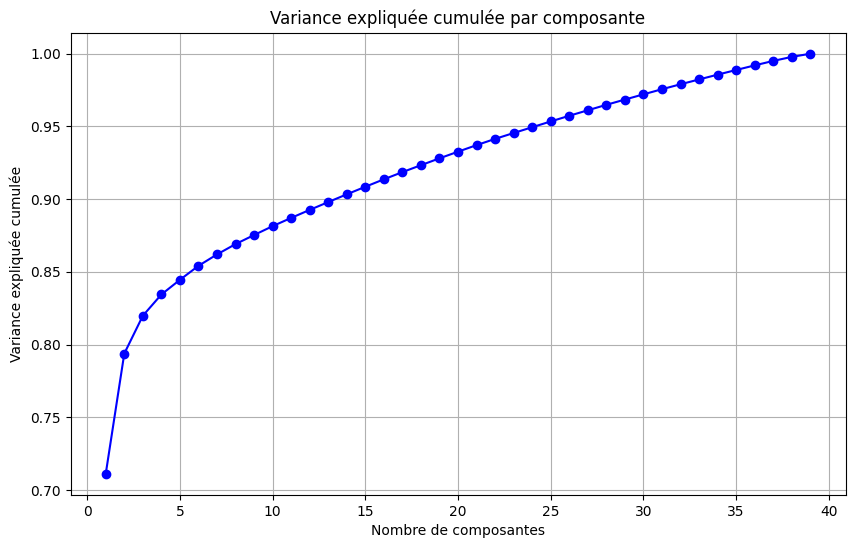

Nombre de composantes retenues pour 82% de variance expliquée : 4


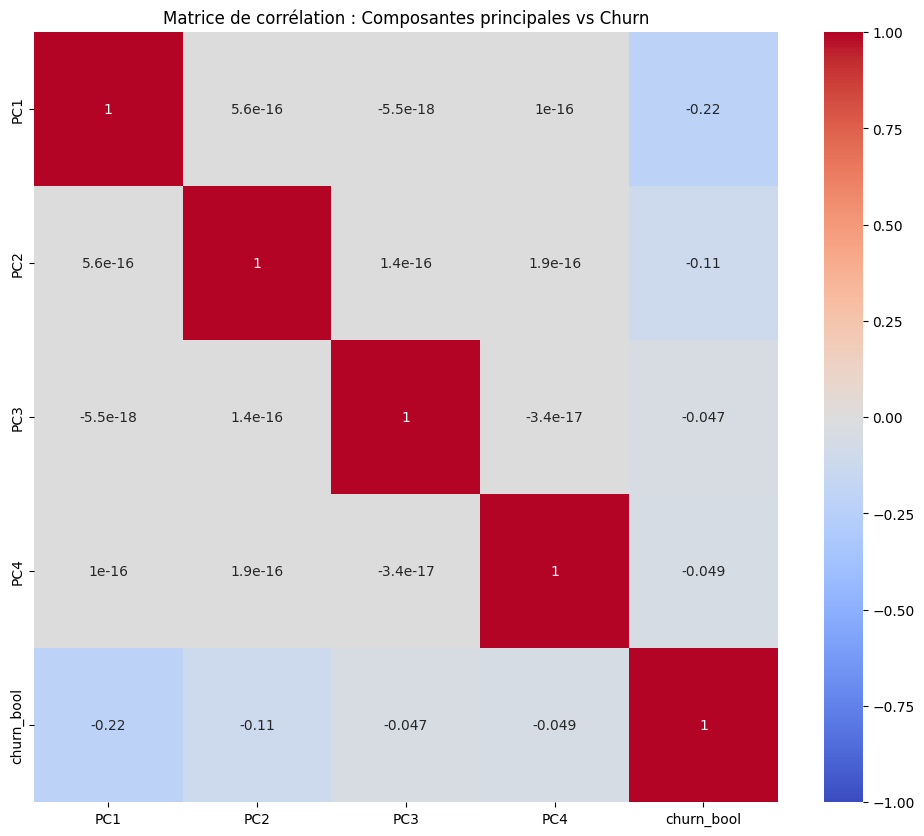

In [29]:
df['churn_bool'] = df['churn'].map({True: 1, False: 0})
var = df.iloc[:, 22:61]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(var)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

var_ratio = pca.explained_variance_ratio_ # Calcul de la variance expliquée cumulée
cum_var_ratio = np.cumsum(var_ratio)

plt.figure(figsize=(10, 6)) # Visualisation de la variance expliquée cumulée
plt.plot(range(1, len(cum_var_ratio) + 1), cum_var_ratio, 'bo-')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée cumulée par composante')
plt.grid(True)
plt.show()

n_components = np.argmax(cum_var_ratio >= 0.82) + 1 # Sélection du nombre de composantes pour lesquelles la variance expliquée est supérieure à 82%
print(f"Nombre de composantes retenues pour 82% de variance expliquée : {n_components}")

pca_final = PCA(n_components=n_components) # Application de l'ACP avec le nombre de composantes sélectionné
X_pca_final = pca_final.fit_transform(X_scaled)

new_columns = [f'PC{i+1}' for i in range(n_components)] # Remplacement des anciennes colonnes par les nouvelles composantes principales
df.drop(df.columns[22:61], axis=1, inplace=True)
df[new_columns] = X_pca_final

plt.figure(figsize=(12, 10)) # Visualisation de la matrice de corrélation entre les composantes principales et le churn
sns.heatmap(df[new_columns + ['churn_bool']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1,linewidths=0, center=0)
plt.title('Matrice de corrélation : Composantes principales vs Churn')
plt.show()

df = df.drop('churn_bool', axis=1)

In [30]:
display(df.head())

,id_client,genre,espace_client_web,assurance_vie,banque_principale,anciennete_mois,compte_epargne,credit_autres,cartes_bancaires,compte_courant,espace_client,PEA,assurance_auto,assurance_habitation,credit_immo,type,compte_titres,methode_contact,agios_6mois,interet_compte_epargne_total,age,segment_client,branche,churn,PC1,PC2,PC3,PC4
0,3463,H,False,False,False,37.0,True,consommation,medium,True,non,non,non,oui,non,pro,True,mail,91.15,3369.25,30.0,A4,NORD-OUEST,False,-1.465611,1.075251,-0.420699,-1.361621
1,1869,H,False,True,True,72.0,True,consommation,premium,NaN,inconnu,inconnu,inconnu,inconnu,inconnu,pro,False,sms,24.10,1734.65,53.0,B1,NORD-OUEST,False,2.202534,1.670018,-0.714063,0.734162
2,3760,H,False,False,False,3.0,True,permanent,medium,False,non,oui,non,non,non,pro,True,sms,73.60,232.50,41.0,B2,NORD-OUEST,False,3.086645,-1.328881,0.406523,0.530878
3,3820,H,True,True,False,72.0,True,consommation,medium,True,oui,oui,oui,non,oui,pro,True,sms,112.90,8061.50,44.0,C4,NORD-OUEST,False,-2.922917,-1.352179,-0.252189,-0.666896
4,1463,F,False,False,False,4.0,True,permanent,medium,False,non,non,non,non,non,pro,False,mail,70.40,281.00,32.0,B2,NORD-OUEST,True,-5.131980,1.491710,-1.470586,0.461202


In [31]:
df.shape

(7035, 28)

### Feature Engineering

Variable score d'engagement

In [32]:
def calculer_score_engagement(row): # Fonction de calcul du score d'engagement, une mesure composite sur une échelle de 0 à 100 qui évalue le niveau d'implication et de fidélité d'un client envers la banque.
    score = 0
    if row['espace_client'] == "oui":
        score += 30
    elif row['espace_client'] == "inconnu":
        score += 10
    elif row['espace_client'] == "non":
        score += 0
    
    if row['espace_client_web'] == True:
        score += 20
    
    score += min(row['anciennete_mois'] / 12 * 5, 50)
    
    produits = ['compte_epargne', 'compte_titres', 'assurance_vie', 'PEA_oui', 
                'assurance_auto_oui', 'assurance_habitation_oui', 'credit_immo_oui',
                'credit_autres_bail', 'credit_autres_consommation', 'credit_autres_permanent']
    
    score += sum(row[produit] for produit in produits if produit in row) * 10
    
    # Pondération pour le type de carte bancaire
    if row['cartes_bancaires'] == "premium":
        score += 20
    elif row['cartes_bancaires'] == "medium":
        score += 15
    elif row['cartes_bancaires'] == "basic":
        score += 10
    
    # Bonus si banque principale
    if row['banque_principale'] == True:
        score += 20
    
    return score


df['score_engagement'] = df.apply(calculer_score_engagement, axis=1)
max_score = df['score_engagement'].max()
df['score_engagement'] = (df['score_engagement'] / max_score) * 100
df['score_engagement'] = df['score_engagement'].round(2)
print(df['score_engagement'].describe())

count    7035.000000
mean       47.398685
std        18.328417
min         7.180000
25%        32.470000
50%        46.840000
75%        61.210000
max       100.000000
Name: score_engagement, dtype: float64


Risque financier

In [33]:
df.head()

,id_client,genre,espace_client_web,assurance_vie,banque_principale,anciennete_mois,compte_epargne,credit_autres,cartes_bancaires,compte_courant,espace_client,PEA,assurance_auto,assurance_habitation,credit_immo,type,compte_titres,methode_contact,agios_6mois,interet_compte_epargne_total,age,segment_client,branche,churn,PC1,PC2,PC3,PC4,score_engagement
0,3463,H,False,False,False,37.0,True,consommation,medium,True,non,non,non,oui,non,pro,True,mail,91.15,3369.25,30.0,A4,NORD-OUEST,False,-1.465611,1.075251,-0.420699,-1.361621,34.77
1,1869,H,False,True,True,72.0,True,consommation,premium,NaN,inconnu,inconnu,inconnu,inconnu,inconnu,pro,False,sms,24.10,1734.65,53.0,B1,NORD-OUEST,False,2.202534,1.670018,-0.714063,0.734162,68.97
2,3760,H,False,False,False,3.0,True,permanent,medium,False,non,oui,non,non,non,pro,True,sms,73.60,232.50,41.0,B2,NORD-OUEST,False,3.086645,-1.328881,0.406523,0.530878,25.00
3,3820,H,True,True,False,72.0,True,consommation,medium,True,oui,oui,oui,non,oui,pro,True,sms,112.90,8061.50,44.0,C4,NORD-OUEST,False,-2.922917,-1.352179,-0.252189,-0.666896,86.21
4,1463,F,False,False,False,4.0,True,permanent,medium,False,non,non,non,non,non,pro,False,mail,70.40,281.00,32.0,B2,NORD-OUEST,True,-5.131980,1.491710,-1.470586,0.461202,18.39


In [34]:
def calculer_score_risque_financier(df): # Fonction de calcul du score de risque financier, une mesure composite sur une échelle de 0 à 100 qui évalue le niveau de risque financier associé à un client.

    df['score_risque_financier'] = 0
    
    df['score_risque_financier'] += df['agios_6mois'] / df['agios_6mois'].max() * 30
    
    credit_risk = {'bail': 10, 'consommation': 15, 'permanent': 20}
    df['score_risque_financier'] += df['credit_autres'].map(credit_risk).fillna(0)
    
    df['score_risque_financier'] += np.maximum(0, 20 - df['anciennete_mois'] / 12)
    
    df['score_risque_financier'] -= ((df['compte_epargne'].astype(int) + df['compte_titres'].astype(int) + (df['PEA'] == 'oui').astype(int)) * 5 +df['assurance_vie'].astype(int) * 10)
    
    df.loc[df['credit_immo'] == 'oui', 'score_risque_financier'] -= 10
    
    df['score_risque_financier'] = np.clip(df['score_risque_financier'], 0, None)
    max_score = df['score_risque_financier'].max()
    df['score_risque_financier'] = (df['score_risque_financier'] / max_score) * 100
    
    df['score_risque_financier'] = df['score_risque_financier'].round(2)
    
    return df

df = calculer_score_risque_financier(df)
print(df[['id_client', 'score_risque_financier']].head())
print(df['score_risque_financier'].describe())

  id_client  score_risque_financier
0      3463                   77.39
1      1869                   34.58
2      3760                   74.63
3      3820                   38.80
4      1463                   90.30
count    7035.000000
mean       56.304986
std        15.981181
min         0.000000
25%        44.285000
50%        57.090000
75%        68.010000
max       100.000000
Name: score_risque_financier, dtype: float64


catégorie d'age

In [35]:
def creer_categorie_age(df): # Fonction pour créer une nouvelle colonne 'categorie_age' à partir de la colonne 'age' en définissant des catégories d'âge.
    bins = [0, 18, 25, 35, 45, 55, 65, np.inf]
    labels = ['Mineur', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
    df['categorie_age'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
    return df

df = creer_categorie_age(df)
print(df[['id_client', 'age', 'categorie_age']].head(10))
print("\nDistribution des catégories d'âge:")
print(df['categorie_age'].value_counts(normalize=True).sort_index())

  id_client   age categorie_age
0      3463  30.0         25-34
1      1869  53.0         45-54
2      3760  41.0         35-44
3      3820  44.0         35-44
4      1463  32.0         25-34
5       688  57.0         55-64
6      2478  27.0         25-34
7       242  71.0           65+
8      3395  30.0         25-34
9      3150  57.0         55-64

Distribution des catégories d'âge:
categorie_age
Mineur    0.000000
18-24     0.091969
25-34     0.239375
35-44     0.268941
45-54     0.165601
55-64     0.120824
65+       0.113291
Name: proportion, dtype: float64


In [36]:
display(df.head())

,id_client,genre,espace_client_web,assurance_vie,banque_principale,anciennete_mois,compte_epargne,credit_autres,cartes_bancaires,compte_courant,espace_client,PEA,assurance_auto,assurance_habitation,credit_immo,type,compte_titres,methode_contact,agios_6mois,interet_compte_epargne_total,age,segment_client,branche,churn,PC1,PC2,PC3,PC4,score_engagement,score_risque_financier,categorie_age
0,3463,H,False,False,False,37.0,True,consommation,medium,True,non,non,non,oui,non,pro,True,mail,91.15,3369.25,30.0,A4,NORD-OUEST,False,-1.465611,1.075251,-0.420699,-1.361621,34.77,77.39,25-34
1,1869,H,False,True,True,72.0,True,consommation,premium,NaN,inconnu,inconnu,inconnu,inconnu,inconnu,pro,False,sms,24.10,1734.65,53.0,B1,NORD-OUEST,False,2.202534,1.670018,-0.714063,0.734162,68.97,34.58,45-54
2,3760,H,False,False,False,3.0,True,permanent,medium,False,non,oui,non,non,non,pro,True,sms,73.60,232.50,41.0,B2,NORD-OUEST,False,3.086645,-1.328881,0.406523,0.530878,25.00,74.63,35-44
3,3820,H,True,True,False,72.0,True,consommation,medium,True,oui,oui,oui,non,oui,pro,True,sms,112.90,8061.50,44.0,C4,NORD-OUEST,False,-2.922917,-1.352179,-0.252189,-0.666896,86.21,38.80,35-44
4,1463,F,False,False,False,4.0,True,permanent,medium,False,non,non,non,non,non,pro,False,mail,70.40,281.00,32.0,B2,NORD-OUEST,True,-5.131980,1.491710,-1.470586,0.461202,18.39,90.30,25-34


In [37]:
df.to_parquet("../data/interim/data.parquet", engine='auto', compression='snappy', index=False)

## Exploratory Data Analysis et statistiques

utiliser PYGwalker ou dtale + aquarel pour rendre matplotlib plus joli

In [38]:
df = pd.read_parquet("../data/interim/data.parquet")

Jetons un oeil aux statistiques globales de notre jeu de donnéee.

In [39]:
display(df.head())

,id_client,genre,espace_client_web,assurance_vie,banque_principale,anciennete_mois,compte_epargne,credit_autres,cartes_bancaires,compte_courant,espace_client,PEA,assurance_auto,assurance_habitation,credit_immo,type,compte_titres,methode_contact,agios_6mois,interet_compte_epargne_total,age,segment_client,branche,churn,PC1,PC2,PC3,PC4,score_engagement,score_risque_financier,categorie_age
0,3463,H,False,False,False,37.0,True,consommation,medium,True,non,non,non,oui,non,pro,True,mail,91.15,3369.25,30.0,A4,NORD-OUEST,False,-1.465611,1.075251,-0.420699,-1.361621,34.77,77.39,25-34
1,1869,H,False,True,True,72.0,True,consommation,premium,None,inconnu,inconnu,inconnu,inconnu,inconnu,pro,False,sms,24.10,1734.65,53.0,B1,NORD-OUEST,False,2.202534,1.670018,-0.714063,0.734162,68.97,34.58,45-54
2,3760,H,False,False,False,3.0,True,permanent,medium,False,non,oui,non,non,non,pro,True,sms,73.60,232.50,41.0,B2,NORD-OUEST,False,3.086645,-1.328881,0.406523,0.530878,25.00,74.63,35-44
3,3820,H,True,True,False,72.0,True,consommation,medium,True,oui,oui,oui,non,oui,pro,True,sms,112.90,8061.50,44.0,C4,NORD-OUEST,False,-2.922917,-1.352179,-0.252189,-0.666896,86.21,38.80,35-44
4,1463,F,False,False,False,4.0,True,permanent,medium,False,non,non,non,non,non,pro,False,mail,70.40,281.00,32.0,B2,NORD-OUEST,True,-5.131980,1.491710,-1.470586,0.461202,18.39,90.30,25-34


Dans un premier temps, scindons notre jeu de données en deux populations, les clients churneurs et les clients actuels de la banque.

In [40]:
attrition = df.loc[df["churn"]==True] #les clients churneurs
not_churn = df.loc[df["churn"]==False] #les autres clients

Nous avons maintenant accès aux statistiques de chaque population, les clients churneurs et les autres.

In [41]:
attrition.describe()

,anciennete_mois,agios_6mois,interet_compte_epargne_total,age,PC1,PC2,PC3,PC4,score_engagement,score_risque_financier
count,1868.000000,1868.000000,1868.000000,1868.000000,1868.000000,1868.000000,1868.000000,1868.000000,1868.000000,1868.000000
mean,17.568522,73.306451,1485.288597,35.222698,-1.918983,-0.336975,-0.078074,-0.061923,40.657323,62.517548
std,19.352096,25.625489,1873.623155,11.372529,3.705888,1.567736,0.937908,0.699332,17.113965,15.400130
min,1.000000,18.850000,18.850000,20.000000,-11.351258,-5.635796,-2.903665,-2.406167,7.180000,2.560000
25%,2.000000,55.000000,99.750000,27.000000,-4.462343,-1.368917,-0.685416,-0.524141,26.150000,52.337500
50%,9.000000,79.325000,655.675000,33.000000,-2.278808,-0.257936,-0.094045,-0.054197,38.510000,64.020000
75%,28.000000,94.100000,2259.325000,40.000000,0.343617,0.728046,0.558345,0.406032,52.010000,74.300000
max,72.000000,118.350000,8127.600000,96.000000,15.387125,4.973934,2.724075,2.619944,99.710000,100.000000


In [42]:
not_churn.describe()

,anciennete_mois,agios_6mois,interet_compte_epargne_total,age,PC1,PC2,PC3,PC4,score_engagement,score_risque_financier
count,5167.000000,5167.000000,5167.000000,5167.000000,5167.000000,5167.000000,5167.000000,5167.000000,5167.000000,5167.000000
mean,36.858332,60.318947,2502.136220,46.503000,0.693760,0.121825,0.028226,0.022387,49.835856,54.058990
std,24.409830,31.281454,2323.375689,16.437505,5.567170,1.856043,1.029282,0.773303,18.143257,15.589607
min,0.000000,18.250000,18.800000,20.000000,-11.106794,-6.313559,-4.333795,-3.384291,7.180000,0.000000
25%,13.000000,24.700000,533.275000,34.000000,-3.224727,-1.100003,-0.623041,-0.463261,35.630000,42.720000
50%,37.000000,62.500000,1636.950000,44.000000,-0.120442,0.058813,0.042148,0.007340,49.710000,54.020000
75%,60.000000,86.975000,4183.800000,57.000000,3.782275,1.220900,0.682879,0.513101,63.220000,65.725000
max,72.000000,118.650000,8496.700000,121.000000,43.505240,9.412612,4.720004,4.986354,100.000000,96.480000


Illustrons les différences entre ces deux populations, en nous concentrant dans un premier temps sur les varibales numériques qui semblent corrélées avec le taux de churn à première vue.

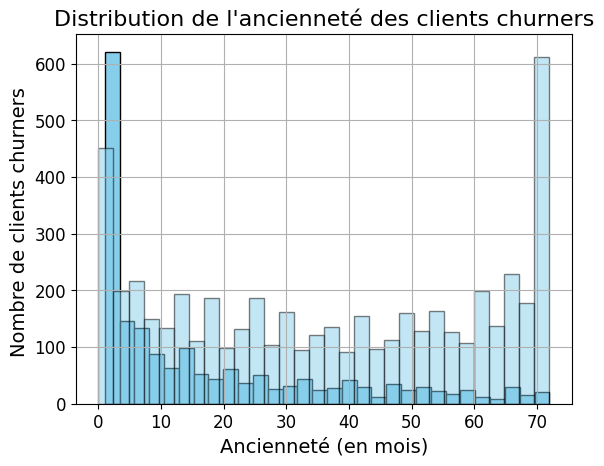

In [43]:
plt.hist(attrition["anciennete_mois"], bins=30, color='skyblue', edgecolor='black', label = 'churn') #histogramme de la répartition des clients churners en fonction de leur ancienneté en tant que client de la banque
plt.hist(not_churn["anciennete_mois"], bins=30, color='skyblue', edgecolor='black', alpha = 0.5, label = 'No Churn') #histogramme de la répartition des clients non churners en fonction de leur ancienneté en tant que client de la banque

plt.title('Distribution de l\'ancienneté des clients churners', fontsize=16)
plt.xlabel('Ancienneté (en mois)', fontsize=14)
plt.ylabel('Nombre de clients churners ', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)

# Afficher le graphique
plt.show()

On déduit de cet histogramme que les churners ont en majorité très peu d'ancienneté en tant que client de la banque. Ils sont même plus nombreux que les non churners entre 0 et 5 mois d'ancienneté.

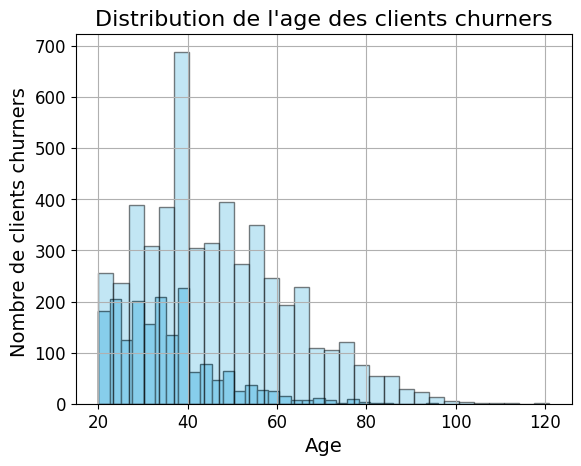

In [44]:
plt.hist(attrition["age"], bins=30, color='skyblue', edgecolor='black') #histogramme de la répartition des clients churners en fonction de leur âge
plt.hist(not_churn["age"], bins=30, color='skyblue', alpha = 0.5, edgecolor='black') #histogramme de la répartition des clients non churners en fonction de leur âge

# Ajouter des titres et des étiquettes
plt.title('Distribution de l\'age des clients churners', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Nombre de clients churners ', fontsize=14)

# Améliorer les axes
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)

# Afficher le graphique
plt.show()

On déduit de cet histogramme que les churners sont en majorité plutôt jeunes.

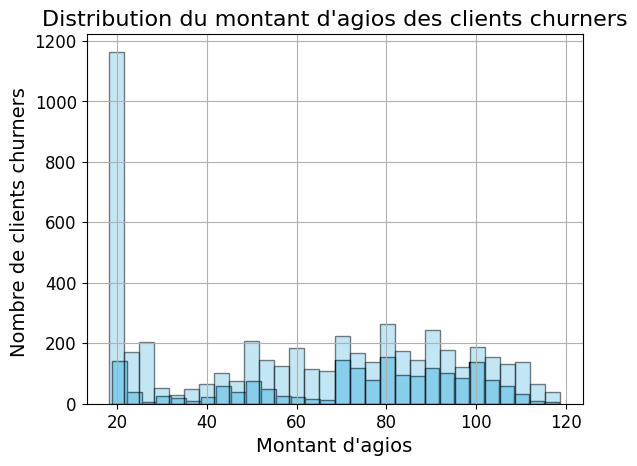

In [45]:
plt.hist(attrition["agios_6mois"], bins=30, color='skyblue', edgecolor='black') #histogramme de la répartition des clients churners en fonction de leur montant d'agios
plt.hist(not_churn["agios_6mois"], bins=30, color='skyblue', alpha = 0.5, edgecolor='black') #histogramme de la répartition des clients non churners en fonction de leur montant d'agios

# Ajouter des titres et des étiquettes
plt.title('Distribution du montant d\'agios des clients churners', fontsize=16)
plt.xlabel('Montant d\'agios', fontsize=14)
plt.ylabel('Nombre de clients churners ', fontsize=14)

# Améliorer les axes
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)

# Afficher le graphique
plt.show()

La répartition des montant d'agios des churners est beaucoup plus uniforme que celle des non churners, donc les churners ont davantage été à découvert lors des 6 derniers mois.

Gestion des variables qualitatives

Jetons un oeil à la répartition des segments clients chez nos poupulations

In [46]:
values = attrition["segment_client"].value_counts().sort_values(ascending=False)

# Convertir en pourcentage
percentage = values / values.sum() * 100

# Afficher les résultats
print(percentage)

segment_client
B2    8.511777
D1    7.280514
B4    6.852248
A3    6.745182
C1    6.638116
A2    6.584582
B3    6.584582
A4    6.584582
D2    6.584582
A1    6.531049
C4    6.531049
D3    6.477516
C2    6.316916
B1    6.102784
C3    5.674518
Name: count, dtype: float64


In [47]:

values = not_churn["segment_client"].value_counts().sort_values(ascending=False)

# Convertir en pourcentage
percentage = values / values.sum() * 100

# Afficher les résultats
print(percentage)

segment_client
B2    13.876524
A1    11.418618
C1    11.263789
D1    11.128314
B1    10.954132
C4    10.683182
C2    10.296110
C3    10.296110
A4    10.083220
Name: count, dtype: float64


Rien de spécialement significatif. On remarque tout de même que les segments A2, A3, B3, B4, D2 et D3 n'existent que dans la populations des churners

In [48]:
values = not_churn["banque_principale"].value_counts().sort_values(ascending=False)
percentage = (values / values.sum()) * 100
print(percentage)

banque_principale
False    66.286046
True     33.713954
Name: count, dtype: float64


In [49]:
values = attrition["banque_principale"].value_counts().sort_values(ascending=False)
percentage = (values / values.sum()) * 100
print(percentage)

banque_principale
False    82.762313
True     17.237687
Name: count, dtype: float64


La banque est davantage la banque principale des non churners que des churners.

In [50]:
values = attrition["compte_epargne"].value_counts().sort_values(ascending=False)
percentage = (values / values.sum()) * 100
print(percentage)

compte_epargne
True     91.11349
False     8.88651
Name: count, dtype: float64


In [51]:
values = not_churn["compte_epargne"].value_counts().sort_values(ascending=False)
percentage = (values / values.sum()) * 100
print(percentage)

compte_epargne
True     90.284498
False     9.715502
Name: count, dtype: float64


Aucune différence significative ici

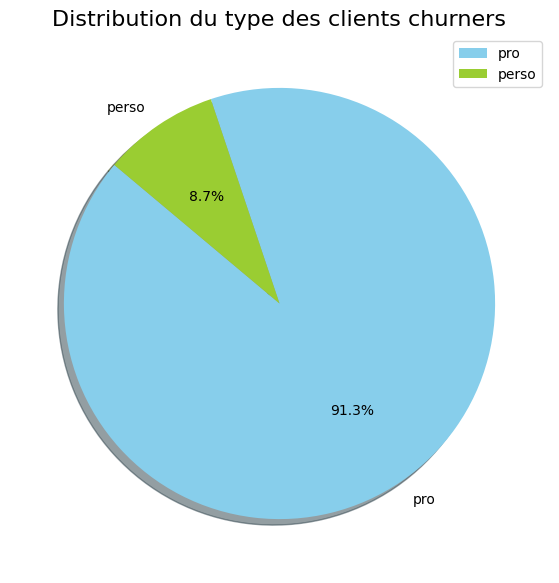

In [52]:
values = attrition["type"].value_counts()
colors = ['skyblue', 'yellowgreen', 'coral', 'gold', 'lightgreen', 'blue', 'pink', 'darkgreen', 'yellow','grey','red','purple']
plt.figure(figsize=(10,7))
plt.pie(values, labels = values.index, autopct='%1.1f%%', startangle=140, colors=colors, shadow=True)
plt.title('Distribution du type des clients churners', fontsize=16)
plt.legend(values.index, loc="best")
plt.show()

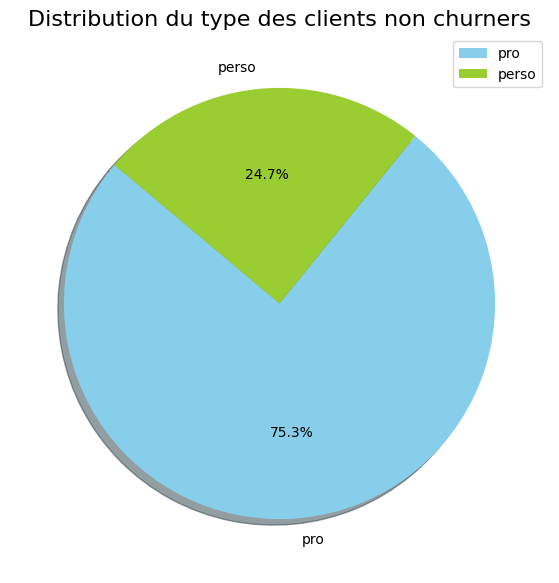

In [53]:
values = not_churn["type"].value_counts()
colors = ['skyblue', 'yellowgreen', 'coral', 'gold', 'lightgreen', 'blue', 'pink', 'darkgreen', 'yellow','grey','red','purple']
plt.figure(figsize=(10,7))
plt.pie(values, labels = values.index, autopct='%1.1f%%', startangle=140, colors=colors, shadow=True)
plt.title('Distribution du type des clients non churners', fontsize=16)
plt.legend(values.index, loc="best")
plt.show()

Les churners sont davantage titulaires de comptes pro alors que la répartition du type de clients chez les non churners semble plutôt uniforme.

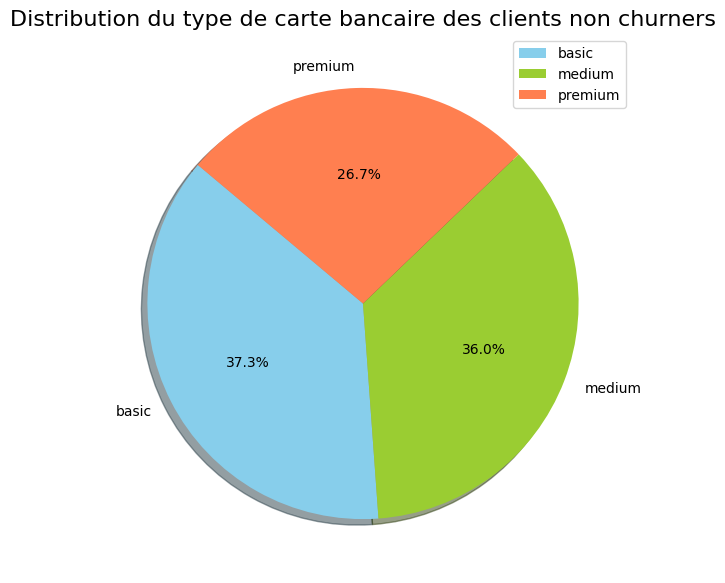

In [54]:
values = not_churn["cartes_bancaires"].value_counts()
colors = ['skyblue', 'yellowgreen', 'coral', 'gold', 'lightgreen', 'blue', 'pink', 'darkgreen', 'yellow','grey','red','purple']
plt.figure(figsize=(10,7))
plt.pie(values, labels = values.index, autopct='%1.1f%%', startangle=140, colors=colors, shadow=True)
plt.title('Distribution du type de carte bancaire des clients non churners', fontsize=16)
plt.legend(values.index, loc="best")
plt.show()

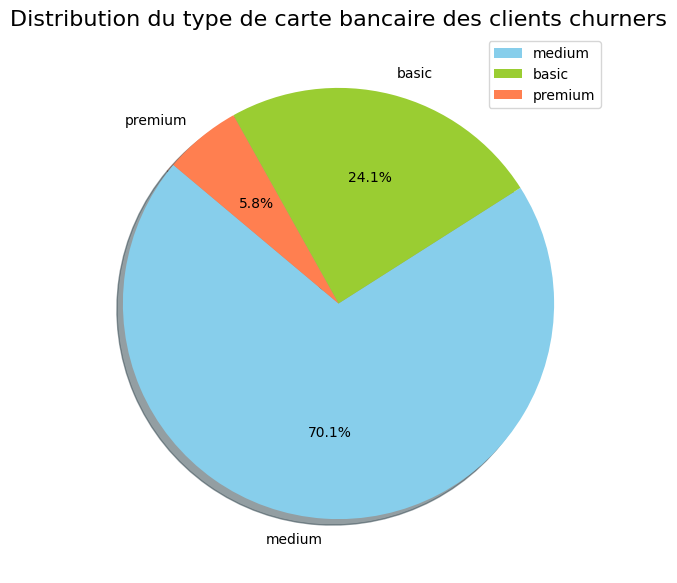

In [55]:
values = attrition["cartes_bancaires"].value_counts()
colors = ['skyblue', 'yellowgreen', 'coral', 'gold', 'lightgreen', 'blue', 'pink', 'darkgreen', 'yellow','grey','red','purple']
plt.figure(figsize=(10,7))
plt.pie(values, labels = values.index, autopct='%1.1f%%', startangle=140, colors=colors, shadow=True)
plt.title('Distribution du type de carte bancaire des clients churners', fontsize=16)
plt.legend(values.index, loc="best")
plt.show()

Les churners sont davantage titulaires d'une carte bancaire medium alors que la répartition des types de carte bancaire chez les non churners semble plutôt uniforme.

## Feature Reduction

Divisons notre jeu de données en deux, X qui comporte toutes les variables et y qui comporte la target

In [56]:
df = pd.read_parquet("../data/interim/data.parquet")

In [57]:
df.head()

,id_client,genre,espace_client_web,assurance_vie,banque_principale,anciennete_mois,compte_epargne,credit_autres,cartes_bancaires,compte_courant,espace_client,PEA,assurance_auto,assurance_habitation,credit_immo,type,compte_titres,methode_contact,agios_6mois,interet_compte_epargne_total,age,segment_client,branche,churn,PC1,PC2,PC3,PC4,score_engagement,score_risque_financier,categorie_age
0,3463,H,False,False,False,37.0,True,consommation,medium,True,non,non,non,oui,non,pro,True,mail,91.15,3369.25,30.0,A4,NORD-OUEST,False,-1.465611,1.075251,-0.420699,-1.361621,34.77,77.39,25-34
1,1869,H,False,True,True,72.0,True,consommation,premium,None,inconnu,inconnu,inconnu,inconnu,inconnu,pro,False,sms,24.10,1734.65,53.0,B1,NORD-OUEST,False,2.202534,1.670018,-0.714063,0.734162,68.97,34.58,45-54
2,3760,H,False,False,False,3.0,True,permanent,medium,False,non,oui,non,non,non,pro,True,sms,73.60,232.50,41.0,B2,NORD-OUEST,False,3.086645,-1.328881,0.406523,0.530878,25.00,74.63,35-44
3,3820,H,True,True,False,72.0,True,consommation,medium,True,oui,oui,oui,non,oui,pro,True,sms,112.90,8061.50,44.0,C4,NORD-OUEST,False,-2.922917,-1.352179,-0.252189,-0.666896,86.21,38.80,35-44
4,1463,F,False,False,False,4.0,True,permanent,medium,False,non,non,non,non,non,pro,False,mail,70.40,281.00,32.0,B2,NORD-OUEST,True,-5.131980,1.491710,-1.470586,0.461202,18.39,90.30,25-34


In [58]:
df = pd.concat([df.drop('churn', axis=1), df['churn']], axis=1)
display(df.head())

,id_client,genre,espace_client_web,assurance_vie,banque_principale,anciennete_mois,compte_epargne,credit_autres,cartes_bancaires,compte_courant,espace_client,PEA,assurance_auto,assurance_habitation,credit_immo,type,compte_titres,methode_contact,agios_6mois,interet_compte_epargne_total,age,segment_client,branche,PC1,PC2,PC3,PC4,score_engagement,score_risque_financier,categorie_age,churn
0,3463,H,False,False,False,37.0,True,consommation,medium,True,non,non,non,oui,non,pro,True,mail,91.15,3369.25,30.0,A4,NORD-OUEST,-1.465611,1.075251,-0.420699,-1.361621,34.77,77.39,25-34,False
1,1869,H,False,True,True,72.0,True,consommation,premium,None,inconnu,inconnu,inconnu,inconnu,inconnu,pro,False,sms,24.10,1734.65,53.0,B1,NORD-OUEST,2.202534,1.670018,-0.714063,0.734162,68.97,34.58,45-54,False
2,3760,H,False,False,False,3.0,True,permanent,medium,False,non,oui,non,non,non,pro,True,sms,73.60,232.50,41.0,B2,NORD-OUEST,3.086645,-1.328881,0.406523,0.530878,25.00,74.63,35-44,False
3,3820,H,True,True,False,72.0,True,consommation,medium,True,oui,oui,oui,non,oui,pro,True,sms,112.90,8061.50,44.0,C4,NORD-OUEST,-2.922917,-1.352179,-0.252189,-0.666896,86.21,38.80,35-44,False
4,1463,F,False,False,False,4.0,True,permanent,medium,False,non,non,non,non,non,pro,False,mail,70.40,281.00,32.0,B2,NORD-OUEST,-5.131980,1.491710,-1.470586,0.461202,18.39,90.30,25-34,True


In [59]:
#One hot encoding des variables catégorielles
catcols = ['genre', 'credit_autres', 'cartes_bancaires','compte_courant', 'espace_client', 'PEA', 'assurance_auto','assurance_habitation', 'credit_immo', 'type', 'methode_contact','segment_client', 'branche',"categorie_age"]
df = pd.get_dummies(df, columns = catcols)
print('New Number of Features: %d'%(df.shape[1])) 

New Number of Features: 76


In [60]:
display(df.head())  

,id_client,espace_client_web,assurance_vie,banque_principale,anciennete_mois,compte_epargne,compte_titres,agios_6mois,interet_compte_epargne_total,age,PC1,PC2,PC3,PC4,score_engagement,score_risque_financier,churn,genre_F,genre_H,credit_autres_bail,credit_autres_consommation,credit_autres_permanent,cartes_bancaires_basic,cartes_bancaires_medium,cartes_bancaires_premium,compte_courant_False,compte_courant_True,espace_client_inconnu,espace_client_non,espace_client_oui,PEA_inconnu,PEA_non,PEA_oui,assurance_auto_inconnu,assurance_auto_non,assurance_auto_oui,assurance_habitation_inconnu,assurance_habitation_non,assurance_habitation_oui,credit_immo_inconnu,credit_immo_non,credit_immo_oui,type_perso,type_pro,methode_contact_courrier,methode_contact_mail,methode_contact_sms,methode_contact_telephone,segment_client_A1,segment_client_A2,segment_client_A3,segment_client_A4,segment_client_B1,segment_client_B2,segment_client_B3,segment_client_B4,segment_client_C1,segment_client_C2,segment_client_C3,segment_client_C4,segment_client_D1,segment_client_D2,segment_client_D3,branche_CENTRE,branche_NORD-EST,branche_NORD-OUEST,branche_OUTRE-MER,branche_SUD-EST,branche_SUD-OUEST,categorie_age_Mineur,categorie_age_18-24,categorie_age_25-34,categorie_age_35-44,categorie_age_45-54,categorie_age_55-64,categorie_age_65+
0,3463,False,False,False,37.0,True,True,91.15,3369.25,30.0,-1.465611,1.075251,-0.420699,-1.361621,34.77,77.39,False,False,True,False,True,False,False,True,False,False,True,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
1,1869,False,True,True,72.0,True,False,24.10,1734.65,53.0,2.202534,1.670018,-0.714063,0.734162,68.97,34.58,False,False,True,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
2,3760,False,False,False,3.0,True,True,73.60,232.50,41.0,3.086645,-1.328881,0.406523,0.530878,25.00,74.63,False,False,True,False,False,True,False,True,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
3,3820,True,True,False,72.0,True,True,112.90,8061.50,44.0,-2.922917,-1.352179,-0.252189,-0.666896,86.21,38.80,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
4,1463,False,False,False,4.0,True,False,70.40,281.00,32.0,-5.131980,1.491710,-1.470586,0.461202,18.39,90.30,True,True,False,False,False,True,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False


Créons la matrice de corrélation du jeu de donnée afin d'avoir un premier aperçu des variables corrélées avec notre target.

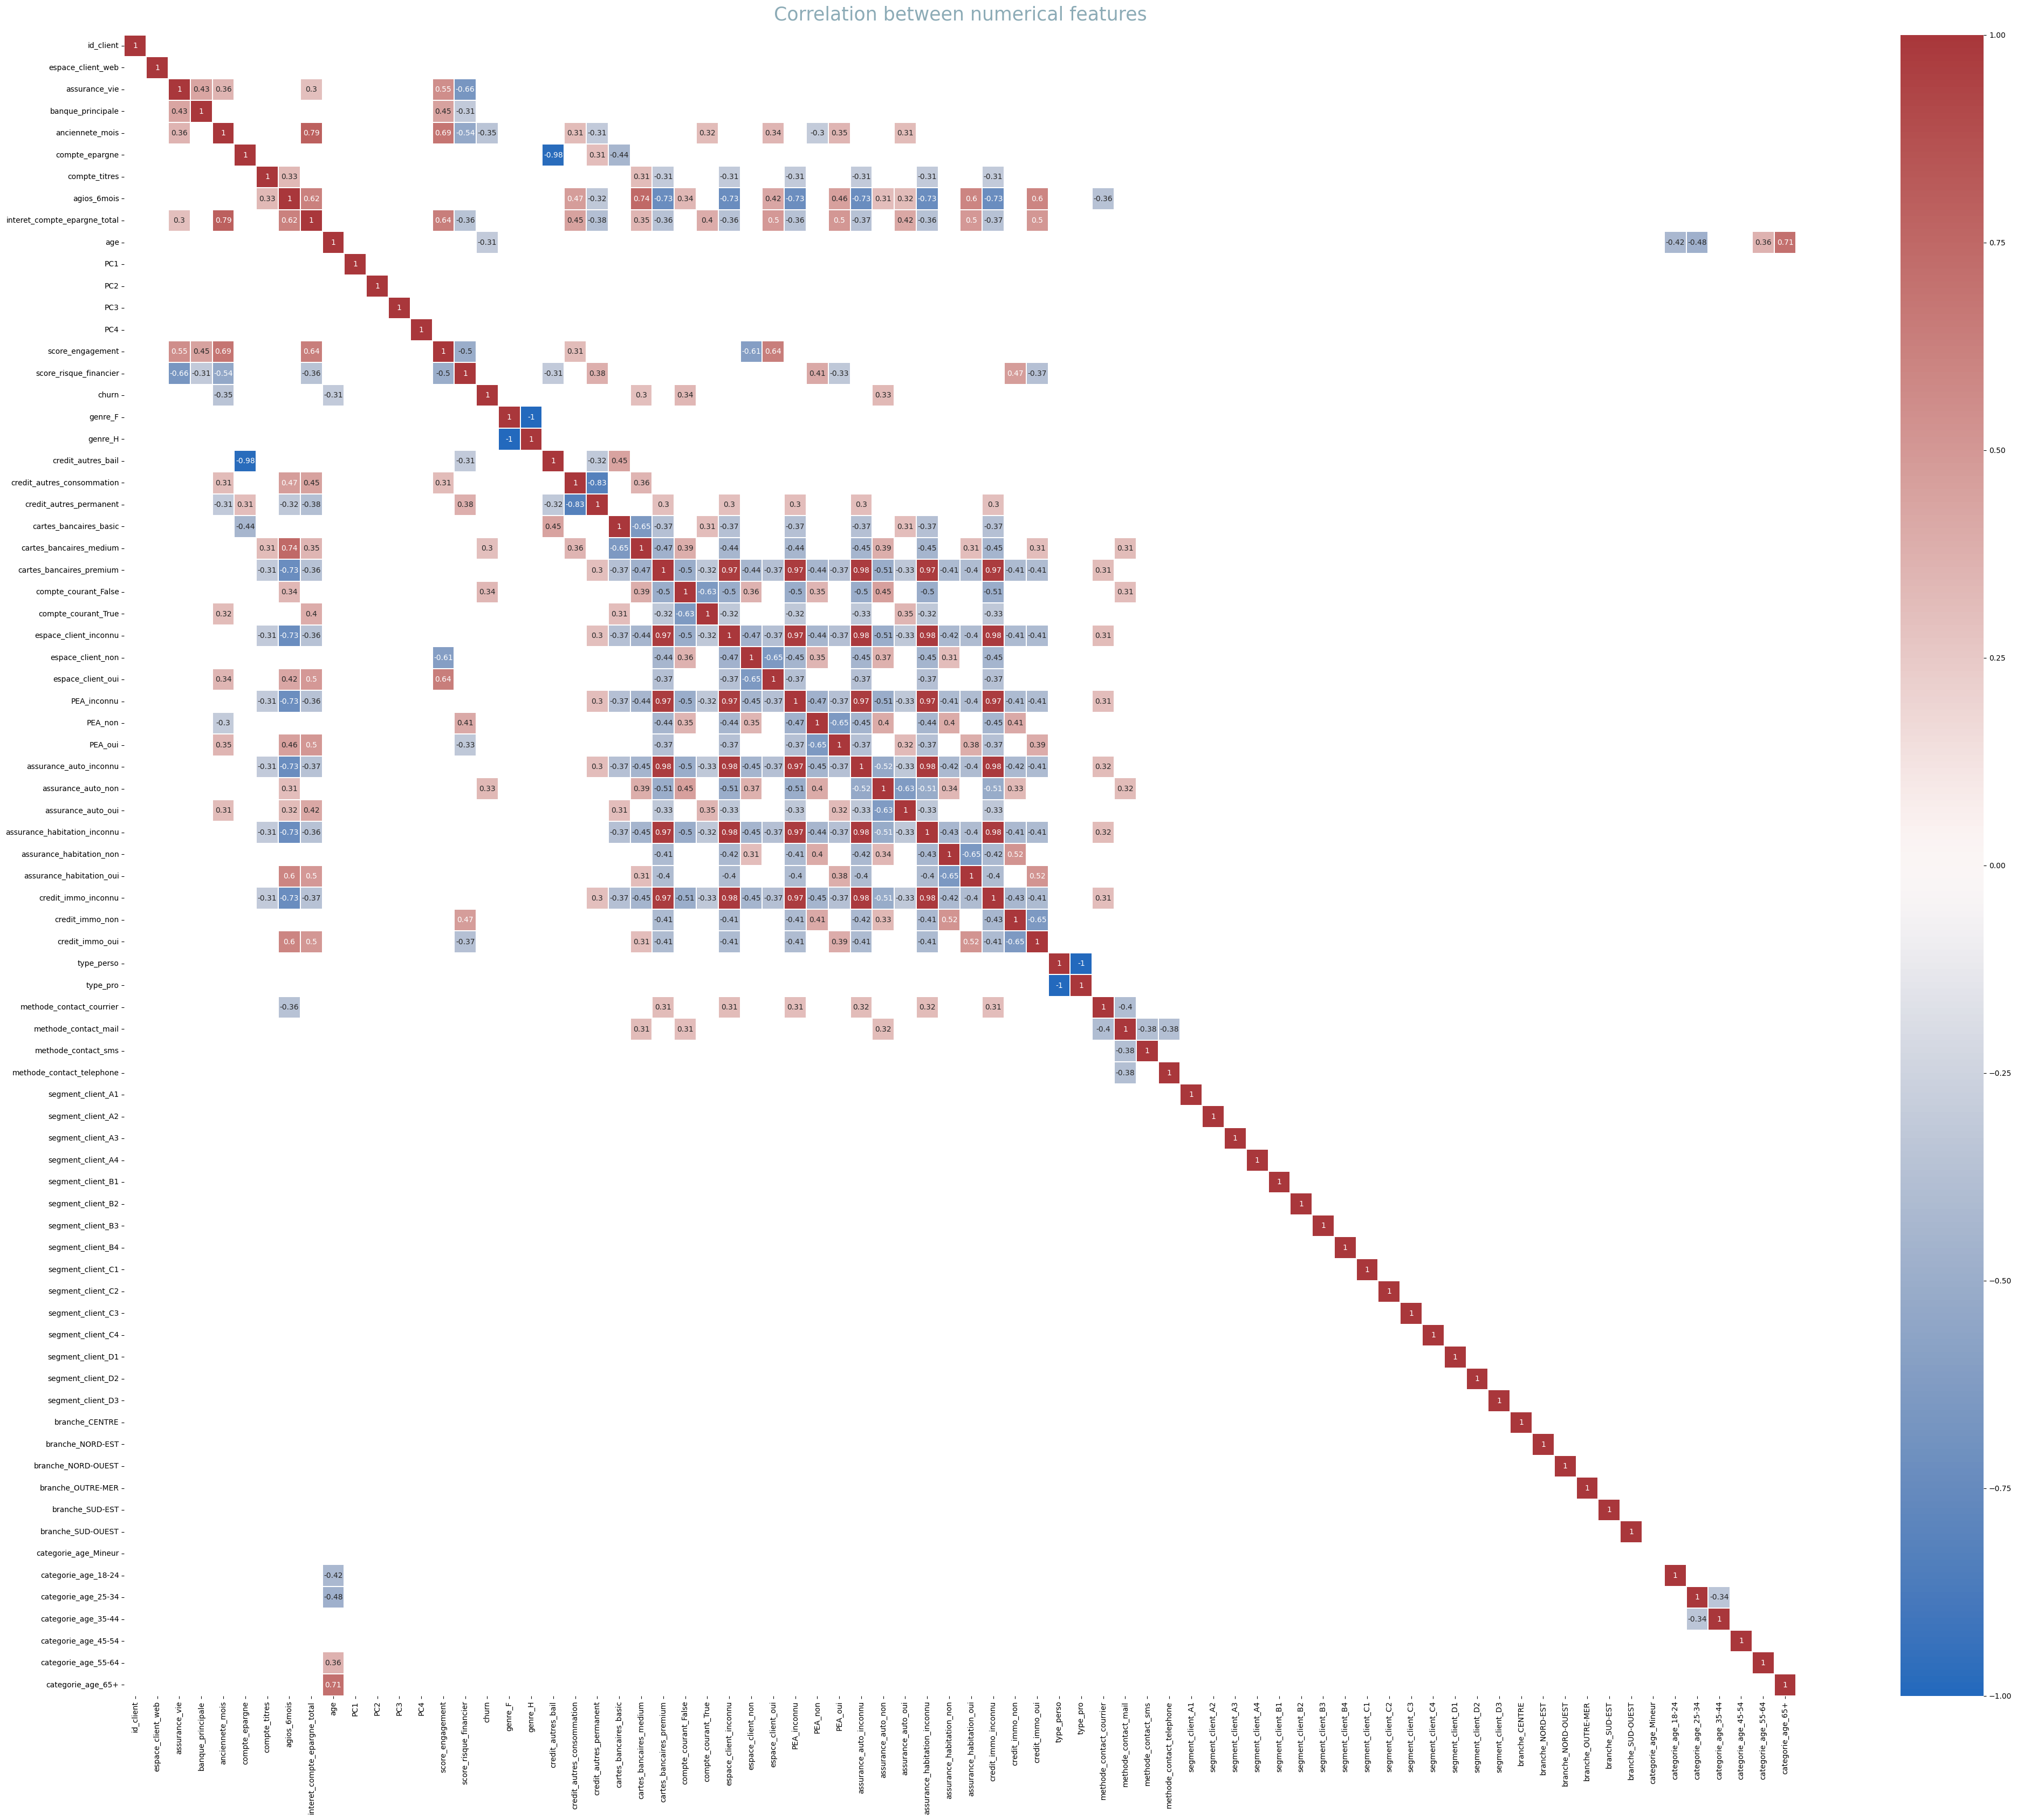

In [61]:
corr=df.corr()[abs(df.corr()) > 0.3] #on part du principe que deux variables sont au moins faiblement corrélées lorsqu'elles ont un coefficient de corrélation supérieur à 0.3 ou inférieur à -0.3
plt.figure(figsize=[50,40])
plt.title("Correlation between numerical features", size = 25, pad = 20, color = '#8cabb6')
sns.heatmap(corr,cmap='vlag', linewidths=0.1, annot=True, linecolor='white')
plt.show()

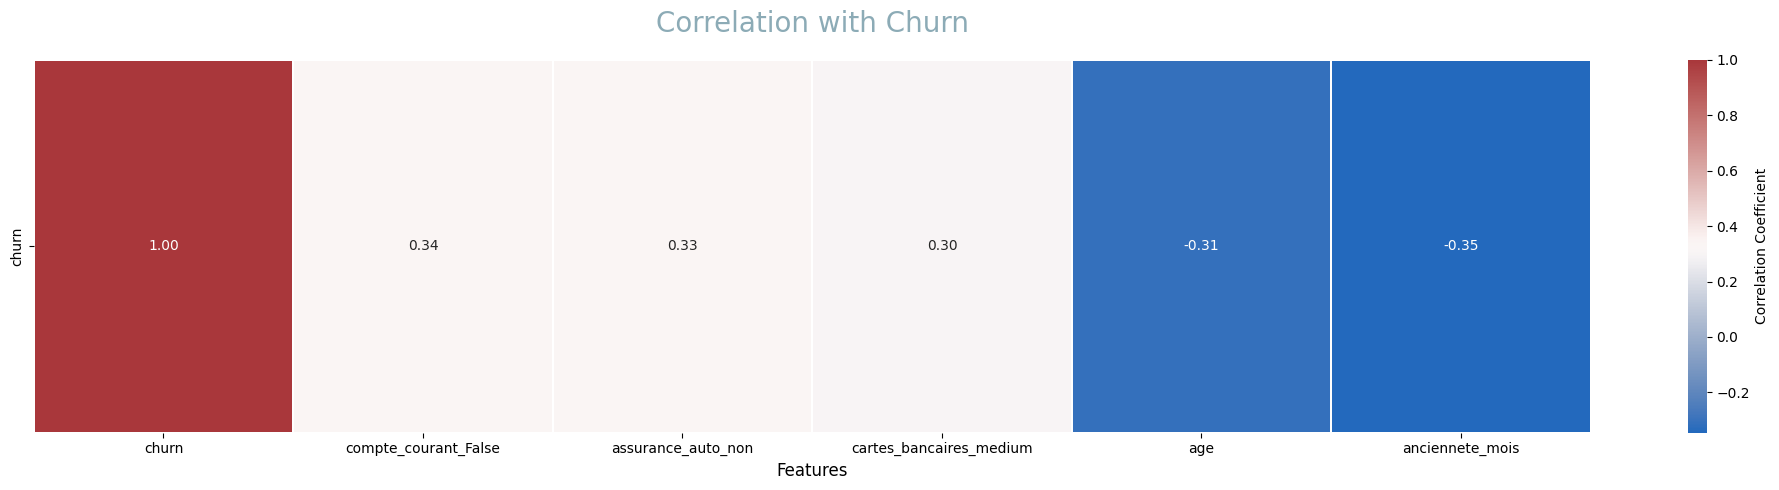

In [62]:
corr = df.corr()['churn']
corr_significant = corr[abs(corr) > 0.3].sort_values(ascending=False)

corr_df = pd.DataFrame(corr_significant).transpose()

plt.figure(figsize=(20, 5))
plt.title("Correlation with Churn", size=20, pad=20, color='#8cabb6')
sns.heatmap(corr_df, cmap='vlag', linewidths=0.1, annot=True, fmt='.2f',linecolor='white',cbar_kws={'label': 'Correlation Coefficient'})
plt.ylabel('')
plt.xlabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

In [63]:
print("Correlation Coefficient of all the Features")
corr = df.corr()
corr = corr.sort_values(["churn"], ascending=False)
correlations = corr["churn"]

significant_corr = correlations[(correlations > 0.3) | (correlations < -0.3)]
top_corr_features = significant_corr.abs().sort_values(ascending=False)
print(top_corr_features)

Correlation Coefficient of all the Features
churn                      1.000000
anciennete_mois            0.345053
compte_courant_False       0.337879
assurance_auto_non         0.330612
age                        0.310409
cartes_bancaires_medium    0.302755
Name: churn, dtype: float64


In [64]:
df.head()

,id_client,espace_client_web,assurance_vie,banque_principale,anciennete_mois,compte_epargne,compte_titres,agios_6mois,interet_compte_epargne_total,age,PC1,PC2,PC3,PC4,score_engagement,score_risque_financier,churn,genre_F,genre_H,credit_autres_bail,credit_autres_consommation,credit_autres_permanent,cartes_bancaires_basic,cartes_bancaires_medium,cartes_bancaires_premium,compte_courant_False,compte_courant_True,espace_client_inconnu,espace_client_non,espace_client_oui,PEA_inconnu,PEA_non,PEA_oui,assurance_auto_inconnu,assurance_auto_non,assurance_auto_oui,assurance_habitation_inconnu,assurance_habitation_non,assurance_habitation_oui,credit_immo_inconnu,credit_immo_non,credit_immo_oui,type_perso,type_pro,methode_contact_courrier,methode_contact_mail,methode_contact_sms,methode_contact_telephone,segment_client_A1,segment_client_A2,segment_client_A3,segment_client_A4,segment_client_B1,segment_client_B2,segment_client_B3,segment_client_B4,segment_client_C1,segment_client_C2,segment_client_C3,segment_client_C4,segment_client_D1,segment_client_D2,segment_client_D3,branche_CENTRE,branche_NORD-EST,branche_NORD-OUEST,branche_OUTRE-MER,branche_SUD-EST,branche_SUD-OUEST,categorie_age_Mineur,categorie_age_18-24,categorie_age_25-34,categorie_age_35-44,categorie_age_45-54,categorie_age_55-64,categorie_age_65+
0,3463,False,False,False,37.0,True,True,91.15,3369.25,30.0,-1.465611,1.075251,-0.420699,-1.361621,34.77,77.39,False,False,True,False,True,False,False,True,False,False,True,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
1,1869,False,True,True,72.0,True,False,24.10,1734.65,53.0,2.202534,1.670018,-0.714063,0.734162,68.97,34.58,False,False,True,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
2,3760,False,False,False,3.0,True,True,73.60,232.50,41.0,3.086645,-1.328881,0.406523,0.530878,25.00,74.63,False,False,True,False,False,True,False,True,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
3,3820,True,True,False,72.0,True,True,112.90,8061.50,44.0,-2.922917,-1.352179,-0.252189,-0.666896,86.21,38.80,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
4,1463,False,False,False,4.0,True,False,70.40,281.00,32.0,-5.131980,1.491710,-1.470586,0.461202,18.39,90.30,True,True,False,False,False,True,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False


In [65]:
df.to_parquet("../data/processed/data.parquet", engine='auto', compression='snappy', index=False)

### Feature selection

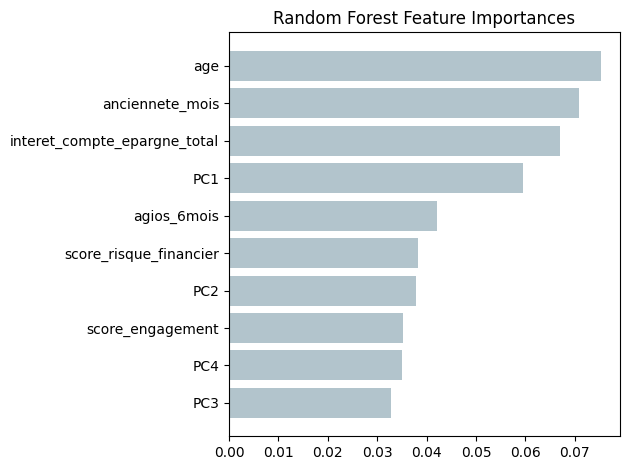

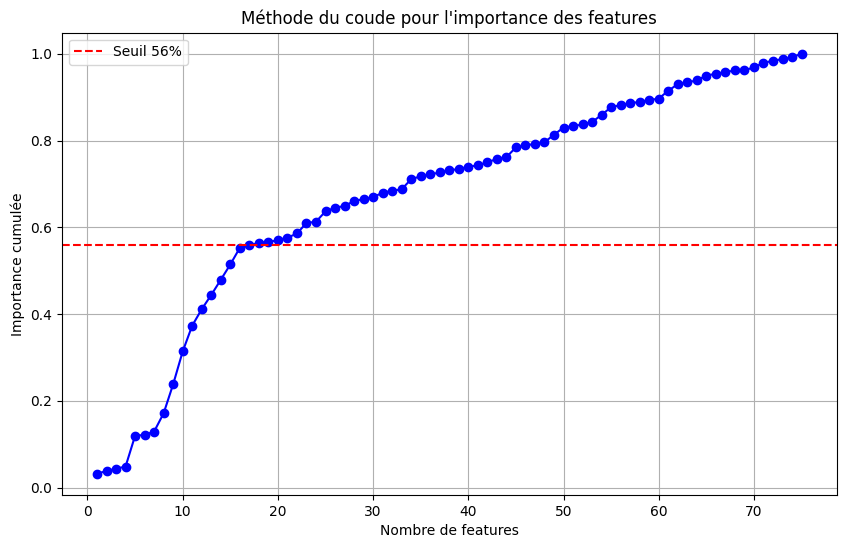

Nombre de features nécessaires pour 58% d'importance cumulée : 17

Features les plus importantes :
                         feature  importance  cumulative_importance
0                            age    0.075393               0.313805
1                anciennete_mois    0.070898               0.119577
2   interet_compte_epargne_total    0.066964               0.238411
3                            PC1    0.059588               0.373393
4                    agios_6mois    0.042161               0.171448
5         score_risque_financier    0.038325               0.552591
6                            PC2    0.037845               0.411238
7               score_engagement    0.035231               0.514266
8                            PC4    0.034933               0.479035
9                            PC3    0.032864               0.444103
10                     id_client    0.032091               0.032091
11       cartes_bancaires_medium    0.024061               0.609876
12          compt

In [66]:
X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def plot_importances(model, model_name, features_to_plot, feature_names):
    model.fit(X,y)
    importances = model.feature_importances_
    indices = np.argsort(importances)
    best_features = np.array(feature_names)[indices][-features_to_plot:]
    values = importances[indices][-features_to_plot:]
    
    y_ticks = np.arange(0, features_to_plot)
    fig, ax = plt.subplots()
    ax.barh(y_ticks, values, color = '#b2c4cc')
    ax.set_yticklabels(best_features)
    ax.set_yticks(y_ticks)
    ax.set_title("%s Feature Importances"%(model_name))
    fig.tight_layout()
    plt.show()
    
feature_names = list(df.columns)
rf_model = RandomForestClassifier(random_state = 1234, n_estimators = 100, max_depth = None, max_features = 'sqrt', min_samples_split = 2, min_samples_leaf = 1,criterion = 'gini',)    
plot_importances(rf_model, 'Random Forest', 10, feature_names)

rf_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
rf_importances['cumulative_importance'] = rf_importances['importance'].cumsum() / rf_importances['importance'].sum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rf_importances) + 1), rf_importances['cumulative_importance'], 'bo-')
plt.xlabel('Nombre de features')
plt.ylabel('Importance cumulée')
plt.title('Méthode du coude pour l\'importance des features')
plt.grid(True)

plt.axhline(y=0.56, color='r', linestyle='--', label='Seuil 56%')

plt.legend()
plt.show()

n_features_95 = (rf_importances['cumulative_importance'] <= 0.56).sum() # Trouver le nombre de features nécessaires pour atteindre 95% d'importance cumulée
print(f"Nombre de features nécessaires pour 58% d'importance cumulée : {n_features_95}")

print("\nFeatures les plus importantes :")
rf_importances = rf_importances.sort_values('importance', ascending=False).reset_index(drop=True)
print(rf_importances.head(n_features_95))

In [67]:
important_features = [
    'age', 'anciennete_mois', 'interet_compte_epargne_total', 'PC1',
    'agios_6mois', 'PC2', 'score_engagement', 'score_risque_financier',
    'PC4'
]

X = df[important_features]
y = df['churn']


### Modelling

Nous cherchons à identifier les churners pour que la banque puisse entamer des démarches pour les retenir.

Notre modèle doit donc être performant pour cibler les churners, la capacité du modèle à identifier les non-churners est moins importante. 

De plus, dans ce cas d'étude, la précision est moins importante que le recall car les erreurs de type 1 (les faux positifs) sont moins handicapants que les erreurs de type 2 (les faux négatifs).

En effet il est généralement plus coûteux de perdre un client existant que de dépenser des ressources sur un faux positif et un recall élevé signifie que le modèle identifie la majorité des clients susceptibles de churner, permettant à l'entreprise d'intervenir de manière proactive. 

Dans le cas de la détection de churn, on préfère souvent avoir plus de faux positifs (clients identifiés à tort comme susceptibles de churner) que de faux négatifs (clients churners non identifiés). 

In [68]:
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

with mlflow.start_run(run_name="RF_HyperparamTuning"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
    rf = RandomForestClassifier(random_state=42)
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
    rf_random.fit(X_train, y_train)
    best_rf = rf_random.best_estimator_
    pred_train = best_rf.predict(X_train)
    pred_test = best_rf.predict(X_test)
    train_accuracy = accuracy_score(y_train, pred_train)
    test_accuracy = accuracy_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test, average='weighted')
    recall = recall_score(y_test, pred_test, average='weighted')
    f1 = f1_score(y_test, pred_test, average='weighted')

    mlflow.log_params(rf_random.best_params_) #enregistre les meilleurs paramètres trouvés par RandomizedSearchCV
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    cm = confusion_matrix(y_test, pred_test) #calcul de la matrice de confusion
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()
    
    clf_report = classification_report(y_test, pred_test) #calcul du rapport de classification
    with open("classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("classification_report.txt")

    feature_imp = pd.DataFrame(sorted(zip(best_rf.feature_importances_, X.columns)), columns=['Value','Feature']) #calcul des importances des features
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.savefig("feature_importances.png")
    mlflow.log_artifact("feature_importances.png")
    plt.close()

    y_scores = best_rf.predict_proba(X_test)[:, 1] #calcul des scores pour la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    mlflow.sklearn.log_model(best_rf, "best_random_forest_model") #enregistre le modèle dans MLflow
    mlflow.set_tag("model_type", "RandomForest_Tuned")
    mlflow.set_tag("data_version", "1.0")
    mlflow.set_tag("model_name", "RF_Tuned")

    print("\nMeilleurs paramètres trouvés:") #affiche les meilleurs paramètres trouvés par RandomizedSearchCV
    print(rf_random.best_params_)
    print("\nMatrice de confusion :")
    print(cm)
    print("\nRapport de classification :")
    print(clf_report)
    print(f"\nAccuracy sur l'ensemble d'entraînement : {train_accuracy:.4f}")
    print(f"Accuracy sur l'ensemble de test : {test_accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")

print("Run terminé. Les informations ont été enregistrées dans MLflow.")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


2024/09/20 09:38:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/20 09:38:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run RF_HyperparamTuning at: http://localhost:5000/#/experiments/214582553551648824/runs/49c654a062894e8486ef710c01afbad7.
2024/09/20 09:38:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/214582553551648824.



Meilleurs paramètres trouvés:
{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 40, 'bootstrap': True}

Matrice de confusion :
[[977  71]
 [165 194]]

Rapport de classification :
              precision    recall  f1-score   support

       False       0.86      0.93      0.89      1048
        True       0.73      0.54      0.62       359

    accuracy                           0.83      1407
   macro avg       0.79      0.74      0.76      1407
weighted avg       0.82      0.83      0.82      1407


Accuracy sur l'ensemble d'entraînement : 0.9314
Accuracy sur l'ensemble de test : 0.8323
Precision : 0.8240
Recall : 0.8323
F1-score : 0.8232
Run terminé. Les informations ont été enregistrées dans MLflow.


Le modèle présente un recall de 0.54 pour les churners, ce qui indique que 45% d'entre eux ne sont pas identifiés, un point à améliorer étant donné l'importance de détecter ces clients. 

Avec une accuracy de 83.23%, le modèle fonctionne globalement bien mais cette métrique est biaisée par les très bonnes performances du modèle sur la classe majoritaire. 

Pour les rééquilibrer, nous vons accès à plusieures approches : un système d epoids pour la classe minoritaire, SMOTE, SMOTEEEN et l'undersampling.

Essayons l'approche systeme de poids pour la classe minoritaire

In [69]:
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

with mlflow.start_run(run_name="RF_HyperparamTuning_Weighted"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))
    rf = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
    rf_random.fit(X_train, y_train)
    best_rf = rf_random.best_estimator_
    pred_train = best_rf.predict(X_train)
    pred_test = best_rf.predict(X_test)

    train_accuracy = accuracy_score(y_train, pred_train)
    test_accuracy = accuracy_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test, average='weighted')
    recall = recall_score(y_test, pred_test, average='weighted')
    f1 = f1_score(y_test, pred_test, average='weighted')

    mlflow.log_params(rf_random.best_params_)
    mlflow.log_param("class_weights", class_weight_dict)
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    cm = confusion_matrix(y_test, pred_test)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    clf_report = classification_report(y_test, pred_test)
    with open("classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("classification_report.txt")

    feature_imp = pd.DataFrame(sorted(zip(best_rf.feature_importances_, X.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.savefig("feature_importances.png")
    mlflow.log_artifact("feature_importances.png")
    plt.close()

    y_scores = best_rf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    mlflow.sklearn.log_model(best_rf, "best_random_forest_model")
    mlflow.set_tag("model_type", "RandomForest_Tuned_Weighted")
    mlflow.set_tag("data_version", "1.0")
    mlflow.set_tag("model_name", "RF_Tuned_Weighted")

    print("\nMeilleurs paramètres trouvés:")
    print(rf_random.best_params_)
    print("\nPoids des classes:")
    print(class_weight_dict)
    print("\nMatrice de confusion :")
    print(cm)
    print("\nRapport de classification :")
    print(clf_report)
    print(f"\nAccuracy sur l'ensemble d'entraînement : {train_accuracy:.4f}")
    print(f"Accuracy sur l'ensemble de test : {test_accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")

print("Run terminé. Les informations ont été enregistrées dans MLflow.")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


2024/09/20 09:42:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/20 09:42:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run RF_HyperparamTuning_Weighted at: http://localhost:5000/#/experiments/214582553551648824/runs/0776d68a57144ff89d7d8c06f177b41a.
2024/09/20 09:42:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/214582553551648824.



Meilleurs paramètres trouvés:
{'n_estimators': 700, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}

Poids des classes:
{False: 0.6831755280407866, True: 1.8648111332007953}

Matrice de confusion :
[[955  93]
 [149 210]]

Rapport de classification :
              precision    recall  f1-score   support

       False       0.87      0.91      0.89      1048
        True       0.69      0.58      0.63       359

    accuracy                           0.83      1407
   macro avg       0.78      0.75      0.76      1407
weighted avg       0.82      0.83      0.82      1407


Accuracy sur l'ensemble d'entraînement : 0.9966
Accuracy sur l'ensemble de test : 0.8280
Precision : 0.8212
Recall : 0.8280
F1-score : 0.8230
Run terminé. Les informations ont été enregistrées dans MLflow.


Le Recall a légèremment augmenté mais ce n'est toujours pas suffisant. On va combiner SMOTE et la pondération des classes.

In [71]:
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

with mlflow.start_run(run_name="RF_SMOTE_Weighted"):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_smote), y=y_train_smote)
    class_weight_dict = dict(zip(np.unique(y_train_smote), class_weights))

    rf = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
    rf_random.fit(X_train_smote, y_train_smote)
    best_rf = rf_random.best_estimator_
    pred_train = best_rf.predict(X_train)  
    pred_test = best_rf.predict(X_test)

    train_accuracy = accuracy_score(y_train, pred_train)
    test_accuracy = accuracy_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test, average='weighted')
    recall = recall_score(y_test, pred_test, average='weighted')
    f1 = f1_score(y_test, pred_test, average='weighted')

    mlflow.log_params(rf_random.best_params_)
    mlflow.log_param("class_weights", class_weight_dict)

    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    cm = confusion_matrix(y_test, pred_test)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    clf_report = classification_report(y_test, pred_test)
    with open("classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("classification_report.txt")

    feature_imp = pd.DataFrame(sorted(zip(best_rf.feature_importances_, X.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.savefig("feature_importances.png")
    mlflow.log_artifact("feature_importances.png")
    plt.close()

    y_scores = best_rf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    mlflow.sklearn.log_model(best_rf, "best_random_forest_model")
    mlflow.set_tag("model_type", "RandomForest_Tuned_SMOTE_Weighted")
    mlflow.set_tag("data_version", "1.0")
    mlflow.set_tag("model_name", "RF_Tuned_SMOTE_Weighted")
    mlflow.set_tag("SMOTE_applied", "Only on training set")

    print("\nMeilleurs paramètres trouvés:")
    print(rf_random.best_params_)
    print("\nPoids des classes:")
    print(class_weight_dict)
    print("\nMatrice de confusion :")
    print(cm)
    print("\nRapport de classification :")
    print(clf_report)
    print(f"\nAccuracy sur l'ensemble d'entraînement : {train_accuracy:.4f}")
    print(f"Accuracy sur l'ensemble de test : {test_accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")

print("Run terminé. Les informations ont été enregistrées dans MLflow.")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


2024/09/20 09:51:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/20 09:51:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run RF_SMOTE_Weighted at: http://localhost:5000/#/experiments/214582553551648824/runs/8fa35f8d714248eda8c46accb5120b57.
2024/09/20 09:51:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/214582553551648824.



Meilleurs paramètres trouvés:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}

Poids des classes:
{False: 1.0, True: 1.0}

Matrice de confusion :
[[913 135]
 [129 230]]

Rapport de classification :
              precision    recall  f1-score   support

       False       0.88      0.87      0.87      1048
        True       0.63      0.64      0.64       359

    accuracy                           0.81      1407
   macro avg       0.75      0.76      0.75      1407
weighted avg       0.81      0.81      0.81      1407


Accuracy sur l'ensemble d'entraînement : 1.0000
Accuracy sur l'ensemble de test : 0.8124
Precision : 0.8134
Recall : 0.8124
F1-score : 0.8129
Run terminé. Les informations ont été enregistrées dans MLflow.


Encore une légère amélioration du Recall. Utilisons SMOTEEEN (SMOTE + Edited Nearest Neighbors) : une technique similaire à SMOTE mais, qui va undesampler la classe majoritaire en plus de générer des exemples synthétiques pour la classe minoritaire.

In [72]:
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

with mlflow.start_run(run_name="RF_SMOTEENN_Weighted"):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    smoteenn = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train_scaled, y_train)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
    class_weight_dict = dict(zip(np.unique(y_train_resampled), class_weights))

    rf = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
    rf_random.fit(X_train_resampled, y_train_resampled)
    best_rf = rf_random.best_estimator_
    pred_train = best_rf.predict(X_train_scaled)  
    pred_test = best_rf.predict(X_test_scaled)

    train_accuracy = accuracy_score(y_train, pred_train)
    test_accuracy = accuracy_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test, average='weighted')
    recall = recall_score(y_test, pred_test, average='weighted')
    f1 = f1_score(y_test, pred_test, average='weighted')

    mlflow.log_params(rf_random.best_params_)
    mlflow.log_param("class_weights", class_weight_dict)
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    cm = confusion_matrix(y_test, pred_test)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    clf_report = classification_report(y_test, pred_test)
    with open("classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("classification_report.txt")

    feature_imp = pd.DataFrame(sorted(zip(best_rf.feature_importances_, X.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.savefig("feature_importances.png")
    mlflow.log_artifact("feature_importances.png")
    plt.close()
    y_scores = best_rf.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    mlflow.sklearn.log_model(best_rf, "best_random_forest_model")
    mlflow.set_tag("model_type", "RandomForest_Tuned_SMOTEENN_Weighted")
    mlflow.set_tag("data_version", "1.0")
    mlflow.set_tag("model_name", "RF_Tuned_SMOTEENN_Weighted")
    mlflow.set_tag("SMOTEENN_applied", "Only on training set")

    print("\nMeilleurs paramètres trouvés:")
    print(rf_random.best_params_)
    print("\nPoids des classes:")
    print(class_weight_dict)
    print("\nMatrice de confusion :")
    print(cm)
    print("\nRapport de classification :")
    print(clf_report)
    print(f"\nAccuracy sur l'ensemble d'entraînement : {train_accuracy:.4f}")
    print(f"Accuracy sur l'ensemble de test : {test_accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")

print("Run terminé. Les informations ont été enregistrées dans MLflow.")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


2024/09/20 09:56:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/20 09:56:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run RF_SMOTEENN_Weighted at: http://localhost:5000/#/experiments/214582553551648824/runs/a6ef41bc88ac4f9ea2e7441afc12b7a0.
2024/09/20 09:56:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/214582553551648824.



Meilleurs paramètres trouvés:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}

Poids des classes:
{False: 1.1968826907301067, True: 0.8587404355503238}

Matrice de confusion :
[[790 258]
 [ 79 280]]

Rapport de classification :
              precision    recall  f1-score   support

       False       0.91      0.75      0.82      1048
        True       0.52      0.78      0.62       359

    accuracy                           0.76      1407
   macro avg       0.71      0.77      0.72      1407
weighted avg       0.81      0.76      0.77      1407


Accuracy sur l'ensemble d'entraînement : 0.8307
Accuracy sur l'ensemble de test : 0.7605
Precision : 0.8099
Recall : 0.7605
F1-score : 0.7732
Run terminé. Les informations ont été enregistrées dans MLflow.


Nous avons ici une nette amélioration du recall pour les churners. L'undersampling est donc peut-être la bonne solution. Utilisons une approche avec une réduction de la classe majoritaire.

In [73]:
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

with mlflow.start_run(run_name="RF_HyperparamTuning_Balanced"):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

    rf = RandomForestClassifier(random_state=42)
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
    rf_random.fit(X_train_resampled, y_train_resampled)
    best_rf = rf_random.best_estimator_
    pred_train = best_rf.predict(X_train)  # Prédictions sur l'ensemble d'entraînement original
    pred_test = best_rf.predict(X_test)

    train_accuracy = accuracy_score(y_train, pred_train)
    test_accuracy = accuracy_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test, average='weighted')
    recall = recall_score(y_test, pred_test, average='weighted')
    f1 = f1_score(y_test, pred_test, average='weighted')

    mlflow.log_params(rf_random.best_params_)
    mlflow.log_param("resampling_method", "RandomUnderSampler")
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    cm = confusion_matrix(y_test, pred_test)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    clf_report = classification_report(y_test, pred_test)
    with open("classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("classification_report.txt")

    feature_imp = pd.DataFrame(sorted(zip(best_rf.feature_importances_, X.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.savefig("feature_importances.png")
    mlflow.log_artifact("feature_importances.png")
    plt.close()

    y_scores = best_rf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    mlflow.sklearn.log_model(best_rf, "best_random_forest_model")
    mlflow.set_tag("model_type", "RandomForest_Tuned_Balanced")
    mlflow.set_tag("data_version", "1.0")
    mlflow.set_tag("model_name", "RF_Tuned_Balanced")

    print("\nMeilleurs paramètres trouvés:")
    print(rf_random.best_params_)
    print("\nMatrice de confusion :")
    print(cm)
    print("\nRapport de classification :")
    print(clf_report)
    print(f"\nAccuracy sur l'ensemble d'entraînement : {train_accuracy:.4f}")
    print(f"Accuracy sur l'ensemble de test : {test_accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")

print("Run terminé. Les informations ont été enregistrées dans MLflow.")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


2024/09/20 10:01:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/20 10:01:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run RF_HyperparamTuning_Balanced at: http://localhost:5000/#/experiments/214582553551648824/runs/c81414c1f53d45fab8c74f3ab1231cff.
2024/09/20 10:01:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/214582553551648824.



Meilleurs paramètres trouvés:
{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}

Matrice de confusion :
[[812 221]
 [ 82 292]]

Rapport de classification :
              precision    recall  f1-score   support

       False       0.91      0.79      0.84      1033
        True       0.57      0.78      0.66       374

    accuracy                           0.78      1407
   macro avg       0.74      0.78      0.75      1407
weighted avg       0.82      0.78      0.79      1407


Accuracy sur l'ensemble d'entraînement : 0.8662
Accuracy sur l'ensemble de test : 0.7846
Precision : 0.8181
Recall : 0.7846
F1-score : 0.7938
Run terminé. Les informations ont été enregistrées dans MLflow.


Les performances de ce modèle et du précédent sont similaires niveau recall mais celui_ci est préférable car il offre un meilleur équilibre entre précision et rappel pour la classe des churners, comme le montre son F1-score plus élevé.

Il maintient également une meilleure accuracy globale et une précision supérieure tout en étant moins complexe que la méthode SMOTEEN + pondération des classes.

Maintenant intéressons nous à un autre modèle : XgBoost

In [74]:
X = df.drop('churn', axis=1)
X['id_client'] = X['id_client'].astype('int64')
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
numerical_cols = X.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

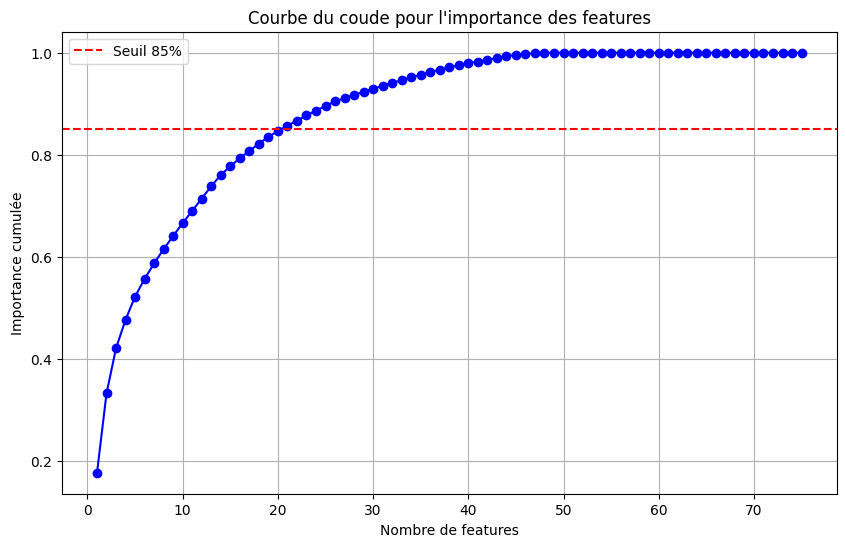

Nombre de features nécessaires pour 85% d'importance cumulée : 20

Features les plus importantes :
                         feature  importance  cumulative_importance
0           compte_courant_False    0.176869               0.176869
1             assurance_auto_non    0.155482               0.332352
2        cartes_bancaires_medium    0.088721               0.421073
3           methode_contact_mail    0.055729               0.476801
4              categorie_age_65+    0.045206               0.522008
5                anciennete_mois    0.034831               0.556839
6                            age    0.030298               0.587136
7              segment_client_B3    0.027777               0.614913
8              segment_client_A3    0.026058               0.640971
9              segment_client_B4    0.024964               0.665935
10             segment_client_A2    0.024235               0.690170
11             segment_client_D2    0.024112               0.714281
12             se

In [77]:
xgb_model = XGBClassifier(random_state=42, n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=0.1, reg_alpha=0.1, reg_lambda=0.1)
xgb_model.fit(X, y) 

xgb_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_  
})

xgb_importances = xgb_importances.sort_values('importance', ascending=False).reset_index(drop=True) 
xgb_importances['cumulative_importance'] = xgb_importances['importance'].cumsum() / xgb_importances['importance'].sum()

plt.figure(figsize=(10, 6)) #plot de l'importance cumulée des features
plt.plot(range(1, len(xgb_importances) + 1), xgb_importances['cumulative_importance'], 'bo-')
plt.xlabel('Nombre de features')
plt.ylabel('Importance cumulée')
plt.title('Courbe du coude pour l\'importance des features')
plt.grid(True)

plt.axhline(y=0.85, color='r', linestyle='--', label='Seuil 85%') #seuil de 85% d'importance cumulée

plt.legend()
plt.show()

n_features_56 = (xgb_importances['cumulative_importance'] <= 0.85).sum() # Trouver le nombre de features nécessaires pour atteindre 85% d'importance cumulée
print(f"Nombre de features nécessaires pour 85% d'importance cumulée : {n_features_56}")

print("\nFeatures les plus importantes :")
print(xgb_importances.head(n_features_56))

In [78]:
important_features = ["assurance_auto_non", "compte_courant_False", "cartes_bancaires_medium", "methode_contact_mail", "categorie_age_65+", "anciennete_mois", "age", "espace_client_non", "segment_client_B3", "segment_client_A3", "segment_client_D2", "segment_client_D3", "segment_client_B4", "segment_client_A2", "PC1", "interet_compte_epargne_total", "type_perso", "compte_titres", "PEA_non"]

X = df[important_features]
y = df['churn']

Ré-utilisons les deux méthodes significativement plus performantes pour le modèle Random Forest. Dans un premier temps, appliquons SMOTEEN et la pondération de classes au modèle XGBoost.

In [79]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

with mlflow.start_run(run_name="XGB_SMOTEENN_Normalized"):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    smoteenn = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)
    xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
    xgb_random.fit(X_train_resampled, y_train_resampled)
    best_xgb = xgb_random.best_estimator_
    pred_train = best_xgb.predict(X_train)
    pred_test = best_xgb.predict(X_test)

    train_accuracy = accuracy_score(y_train, pred_train)
    test_accuracy = accuracy_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test, average='weighted')
    recall = recall_score(y_test, pred_test, average='weighted')
    f1 = f1_score(y_test, pred_test, average='weighted')

    mlflow.log_params(xgb_random.best_params_)
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    cm = confusion_matrix(y_test, pred_test)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    clf_report = classification_report(y_test, pred_test)
    with open("classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("classification_report.txt")

    feature_imp = pd.DataFrame(sorted(zip(best_xgb.feature_importances_, X.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.savefig("feature_importances.png")
    mlflow.log_artifact("feature_importances.png")
    plt.close()

    y_scores = best_xgb.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    mlflow.xgboost.log_model(best_xgb, "best_xgboost_model")
    mlflow.set_tag("model_type", "XGBoost_Tuned_SMOTEENN_Normalized")
    mlflow.set_tag("data_version", "1.0")
    mlflow.set_tag("model_name", "XGB_Tuned_SMOTEENN_Normalized")
    mlflow.set_tag("SMOTEENN_applied", "Only on training set")
    print("\nMeilleurs paramètres trouvés:")
    print(xgb_random.best_params_)
    print("\nMatrice de confusion :")
    print(cm)
    print("\nRapport de classification :")
    print(clf_report)
    print(f"\nAccuracy sur l'ensemble d'entraînement : {train_accuracy:.4f}")
    print(f"Accuracy sur l'ensemble de test : {test_accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")

print("Run terminé. Les informations ont été enregistrées dans MLflow.")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


2024/09/20 10:14:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/20 10:14:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_SMOTEENN_Normalized at: http://localhost:5000/#/experiments/214582553551648824/runs/4e746ee7700d4c63b92e0edabe3c682a.
2024/09/20 10:14:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/214582553551648824.



Meilleurs paramètres trouvés:
{'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.5}

Matrice de confusion :
[[867 181]
 [ 73 286]]

Rapport de classification :
              precision    recall  f1-score   support

       False       0.92      0.83      0.87      1048
        True       0.61      0.80      0.69       359

    accuracy                           0.82      1407
   macro avg       0.77      0.81      0.78      1407
weighted avg       0.84      0.82      0.83      1407


Accuracy sur l'ensemble d'entraînement : 0.8527
Accuracy sur l'ensemble de test : 0.8195
Precision : 0.8433
Recall : 0.8195
F1-score : 0.8264
Run terminé. Les informations ont été enregistrées dans MLflow.


Ce modèle est une amélioration par rapports aux modèles Randorm Forest car le recall est légèremment plus élevé, tout comme l'ensemble des métriques. Testons la seconde approche avec under sampling

In [81]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}


with mlflow.start_run(run_name="XGB_RUS_Normalized"):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
    
    xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
    xgb_random.fit(X_train_resampled, y_train_resampled)
    best_xgb = xgb_random.best_estimator_
    pred_train = best_xgb.predict(X_train)
    pred_test = best_xgb.predict(X_test)

    train_accuracy = accuracy_score(y_train, pred_train)
    test_accuracy = accuracy_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test, average='weighted')
    recall = recall_score(y_test, pred_test, average='weighted')
    f1 = f1_score(y_test, pred_test, average='weighted')

    mlflow.log_params(xgb_random.best_params_)
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    cm = confusion_matrix(y_test, pred_test)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    clf_report = classification_report(y_test, pred_test)
    with open("classification_report.txt", "w") as f:
        f.write(clf_report)
    mlflow.log_artifact("classification_report.txt")

    feature_imp = pd.DataFrame(sorted(zip(best_xgb.feature_importances_, X.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.savefig("feature_importances.png")
    mlflow.log_artifact("feature_importances.png")
    plt.close()
    
    y_scores = best_xgb.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    mlflow.sklearn.log_model(best_xgb, "best_xgboost_model")
    mlflow.set_tag("model_type", "XGBoost_Tuned_RUS_Normalized")
    mlflow.set_tag("data_version", "1.0")
    mlflow.set_tag("model_name", "XGB_Tuned_RUS_Normalized")
    mlflow.set_tag("RUS_applied", "Only on training set")

    print("\nMeilleurs paramètres trouvés:")
    print(xgb_random.best_params_)
    print("\nMatrice de confusion :")
    print(cm)
    print("\nRapport de classification :")
    print(clf_report)
    print(f"\nAccuracy sur l'ensemble d'entraînement : {train_accuracy:.4f}")
    print(f"Accuracy sur l'ensemble de test : {test_accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")

print("Run terminé. Les informations ont été enregistrées dans MLflow.")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


2024/09/20 10:26:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/20 10:26:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_RUS_Normalized at: http://localhost:5000/#/experiments/214582553551648824/runs/9fe68c651de04b2b9882311b20865668.
2024/09/20 10:26:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/214582553551648824.



Meilleurs paramètres trouvés:
{'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}

Matrice de confusion :
[[880 168]
 [ 64 295]]

Rapport de classification :
              precision    recall  f1-score   support

       False       0.93      0.84      0.88      1048
        True       0.64      0.82      0.72       359

    accuracy                           0.84      1407
   macro avg       0.78      0.83      0.80      1407
weighted avg       0.86      0.84      0.84      1407


Accuracy sur l'ensemble d'entraînement : 0.8708
Accuracy sur l'ensemble de test : 0.8351
Precision : 0.8569
Recall : 0.8351
F1-score : 0.8412
Run terminé. Les informations ont été enregistrées dans MLflow.


Encore une fois l'undersampling semble être la meilleure méthode, toute les métriques sur supérieure d'un à quatre % par rapport à la méthode SMOTEEEN + pondération des classes.

Tentative stacking de modèles : Plutôt que de choisir un seul modèle, utilisons une combinaison de plusieurs modèles pour améliorer la performance. Le stacking consiste à entraîner plusieurs modèles de base et à utiliser leurs prédictions comme features dans un modèle méta. Il est recommandé d'utiliser des modèles différents pour maximiser les performances, nous allons donc utiliser le modèle RAndom Forest avec la méthode SMOTEEEN et le modèle XGBoost avec undersmapling.

In [84]:
xgb_features = ["assurance_auto_non", "compte_courant_False", "cartes_bancaires_medium", "methode_contact_mail", "categorie_age_65+", "anciennete_mois", "age", "espace_client_non", "segment_client_B3", "segment_client_A3", "segment_client_D2", "segment_client_D3", "segment_client_B4", "segment_client_A2", "PC1", "interet_compte_epargne_total", "type_perso", "compte_titres", "PEA_non"]

rf_features = ['age', 'anciennete_mois', 'interet_compte_epargne_total', 'PC1', 'agios_6mois', 'PC2', 'score_engagement', 'score_risque_financier', 'PC4']

X_xgb = df[xgb_features]
X_rf = df[rf_features]
y = df['churn']

X_xgb_train, X_xgb_test, X_rf_train, X_rf_test, y_train, y_test = train_test_split(X_xgb, X_rf, y, test_size=0.2, random_state=42)

best_xgb = mlflow.sklearn.load_model("runs:/9fe68c651de04b2b9882311b20865668/best_xgboost_model")
best_rf = mlflow.sklearn.load_model("runs:/a6ef41bc88ac4f9ea2e7441afc12b7a0/best_random_forest_model")

with mlflow.start_run(run_name="Improved_Stacking_Model_with_Undersampling"):
    
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    meta_features = np.zeros((X_xgb_train.shape[0], 2))
    
    for fold, (train_index, val_index) in enumerate(skf.split(X_xgb_train, y_train)):
        X_xgb_fold_train, X_xgb_fold_val = X_xgb_train.iloc[train_index], X_xgb_train.iloc[val_index]
        X_rf_fold_train, X_rf_fold_val = X_rf_train.iloc[train_index], X_rf_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        xgb_fold_pred = best_xgb.predict_proba(X_xgb_fold_val)[:, 1]
        rf_fold_pred = best_rf.predict_proba(X_rf_fold_val)[:, 1]
        
        meta_features[val_index, 0] = xgb_fold_pred
        meta_features[val_index, 1] = rf_fold_pred
    
    scaler = StandardScaler()
    meta_features_scaled = scaler.fit_transform(meta_features)
    
    X_meta_train = meta_features_scaled

    rus = RandomUnderSampler(random_state=42)
    X_meta_train_resampled, y_train_resampled = rus.fit_resample(X_meta_train, y_train)

    meta_models = {
        'LogisticRegression': LogisticRegression(random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(random_state=42)
    }
    
    best_meta_model = None
    best_meta_score = 0
    
    for name, model in meta_models.items():
        model.fit(X_meta_train_resampled, y_train_resampled)
        score = model.score(X_meta_train_resampled, y_train_resampled)
        if score > best_meta_score:
            best_meta_score = score
            best_meta_model = model
    
    print(f"Best meta-model: {type(best_meta_model).__name__}")

    xgb_test_pred = best_xgb.predict_proba(X_xgb_test)[:, 1]
    rf_test_pred = best_rf.predict_proba(X_rf_test)[:, 1]
    X_meta_test = scaler.transform(np.column_stack((xgb_test_pred, rf_test_pred)))
    
    final_predictions = best_meta_model.predict(X_meta_test)
    final_predictions_proba = best_meta_model.predict_proba(X_meta_test)[:, 1]

    accuracy = accuracy_score(y_test, final_predictions)
    precision = precision_score(y_test, final_predictions, average='weighted')
    recall = recall_score(y_test, final_predictions, average='weighted')
    f1 = f1_score(y_test, final_predictions, average='weighted')
    auc = roc_auc_score(y_test, final_predictions_proba)

    cm = confusion_matrix(y_test, final_predictions)
    clf_report = classification_report(y_test, final_predictions)

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("auc", auc)

    mlflow.sklearn.log_model(best_meta_model, "best_meta_model")

    mlflow.set_tag("model_type", "Improved_Stacking_XGB_RF_with_Undersampling")
    mlflow.set_tag("meta_model", type(best_meta_model).__name__)
    mlflow.set_tag("xgb_model_run_id", "19c93e91d28a4a77b512624deb0fb038")
    mlflow.set_tag("rf_model_run_id", "b116f01518d64491b9d3f823f0ab77fb")

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    print("\nMatrice de confusion:")
    print(cm)

    print("\nRapport de classification:")
    print(clf_report)

    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Matrice de confusion')
    plt.ylabel('Valeur réelle')
    plt.xlabel('Valeur prédite')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

print("Run terminé. Les informations ont été enregistrées dans MLflow.")

Best meta-model: RandomForestClassifier


2024/09/20 10:45:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy: 0.8145
Precision: 0.8440
Recall: 0.8145
F1-score: 0.8225
AUC: 0.9001

Matrice de confusion:
[[854 194]
 [ 67 292]]

Rapport de classification:
              precision    recall  f1-score   support

       False       0.93      0.81      0.87      1048
        True       0.60      0.81      0.69       359

    accuracy                           0.81      1407
   macro avg       0.76      0.81      0.78      1407
weighted avg       0.84      0.81      0.82      1407



2024/09/20 10:45:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run Improved_Stacking_Model_with_Undersampling at: http://localhost:5000/#/experiments/214582553551648824/runs/0c1a535026d04dbeb1e1127aa107cc4d.
2024/09/20 10:45:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/214582553551648824.


Run terminé. Les informations ont été enregistrées dans MLflow.


Le modèle xgboost avec undersampling reste meilleur. Nous allons donc l'utiliser pour créer nos scores.

In [86]:
best_xgb_model = mlflow.sklearn.load_model("runs:/9fe68c651de04b2b9882311b20865668/best_xgboost_model")

expected_features = best_xgb_model.feature_names_in_

X = df[expected_features]
y = df['churn']
#X['id_client'] = X['id_client'].astype(int)

churn_probabilities = best_xgb_model.predict_proba(X)[:, 1]

df['churn_score'] = churn_probabilities

print(df[['churn', 'churn_score']].head())

print(df['churn_score'].describe())

   churn  churn_score
0  False     0.740205
1  False     0.006041
2  False     0.676783
3  False     0.025739
4   True     0.863720
count    7035.000000
mean        0.368304
std         0.351878
min         0.000911
25%         0.056883
50%         0.213937
75%         0.689943
max         0.999371
Name: churn_score, dtype: float64


In [87]:
df_sorted = df.sort_values(by='churn_score', ascending=False)
df_sorted.head(20)

,id_client,espace_client_web,assurance_vie,banque_principale,anciennete_mois,compte_epargne,compte_titres,agios_6mois,interet_compte_epargne_total,age,PC1,PC2,PC3,PC4,score_engagement,score_risque_financier,churn,genre_F,genre_H,credit_autres_bail,credit_autres_consommation,credit_autres_permanent,cartes_bancaires_basic,cartes_bancaires_medium,cartes_bancaires_premium,compte_courant_False,compte_courant_True,espace_client_inconnu,espace_client_non,espace_client_oui,PEA_inconnu,PEA_non,PEA_oui,assurance_auto_inconnu,assurance_auto_non,assurance_auto_oui,assurance_habitation_inconnu,assurance_habitation_non,assurance_habitation_oui,credit_immo_inconnu,credit_immo_non,credit_immo_oui,type_perso,type_pro,methode_contact_courrier,methode_contact_mail,methode_contact_sms,methode_contact_telephone,segment_client_A1,segment_client_A2,segment_client_A3,segment_client_A4,segment_client_B1,segment_client_B2,segment_client_B3,segment_client_B4,segment_client_C1,segment_client_C2,segment_client_C3,segment_client_C4,segment_client_D1,segment_client_D2,segment_client_D3,branche_CENTRE,branche_NORD-EST,branche_NORD-OUEST,branche_OUTRE-MER,branche_SUD-EST,branche_SUD-OUEST,categorie_age_Mineur,categorie_age_18-24,categorie_age_25-34,categorie_age_35-44,categorie_age_45-54,categorie_age_55-64,categorie_age_65+,churn_score
1309,2448,True,False,False,14.0,True,True,104.85,1531.40,21.0,-4.362162,-1.375907,-0.194061,0.056048,62.64,60.83,True,True,False,False,True,False,False,True,False,True,False,False,False,True,False,False,True,False,True,False,False,False,True,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,0.999371
5994,2291,False,False,False,4.0,True,True,85.65,321.65,25.0,-3.777210,-0.710787,-0.479752,0.562063,25.29,79.73,True,True,False,False,True,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,0.999310
75,3384,False,True,True,4.0,True,True,73.75,325.45,22.0,-3.758876,-0.800868,0.141979,0.781392,45.98,57.34,True,True,False,False,False,True,False,True,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,0.999303
6692,771,False,False,False,15.0,True,True,93.35,1444.65,35.0,-4.062615,-0.188169,0.348275,0.926753,28.45,64.29,True,False,True,False,True,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,0.999249
2460,976,False,False,False,1.0,True,True,69.90,69.90,28.0,-2.594195,1.162095,-1.889378,-0.013637,24.43,81.91,True,False,True,False,False,True,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,0.999232
4675,6764,False,False,False,1.0,True,True,69.20,69.20,26.0,-3.671174,-1.134191,0.554798,-0.050423,24.43,81.60,True,True,False,False,False,True,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [88]:
df['churn_class'] = pd.cut(df['churn_score'] * 100, bins=[-1, 20, 40, 60, 80, 100], labels=["Very Low", "Low", "Average", "High Risk", "Very High Risk"])
print(df[['churn_score', 'churn_class']].head())

   churn_score     churn_class
0     0.740205       High Risk
1     0.006041        Very Low
2     0.676783       High Risk
3     0.025739        Very Low
4     0.863720  Very High Risk


In [89]:
df.to_excel('C:/Users/loick/Desktop/churn_prediction/docs/df.xlsx', index=False)

faire appli streamlit

Github, FastAPI, Airflow, docker, cloud : étudier comment utiliser plus de ceci